<a href="https://colab.research.google.com/github/ShlomiShorIII/CharacterMap/blob/main/CharcterMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

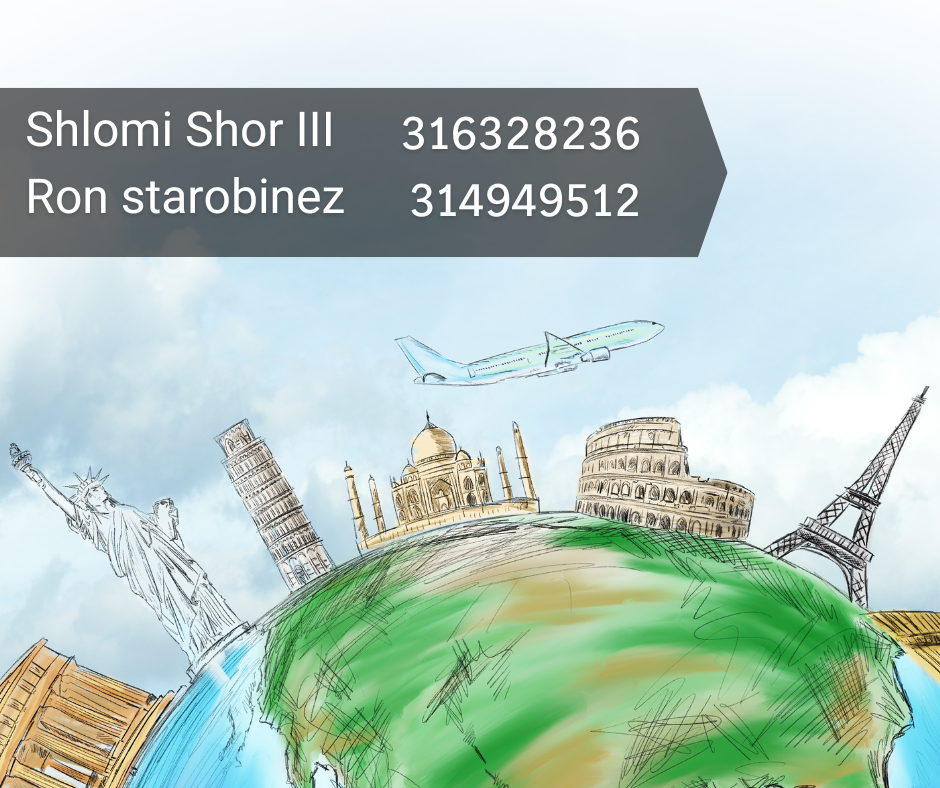

# ***Install***

In [ ]:
print("Hello!")

In [ ]:
%%capture

! pip install gdown
! pip install PyMuPDF
! pip install python-Levenshtein
! pip install networkx matplotlib
! pip install spacy

In [ ]:
import re
import os
import fitz
import gdown
import Levenshtein
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [ ]:
#Loading the book

file_id = '1m3zgJ2877lGePrFRqYZJ4kGEwaEKTJFj'
url = f'https://drive.google.com/uc?id={file_id}'

pdf_path = 'my_book.pdf'
gdown.download(url, pdf_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1m3zgJ2877lGePrFRqYZJ4kGEwaEKTJFj
To: /content/my_book.pdf
100%|██████████| 1.32M/1.32M [00:00<00:00, 74.8MB/s]


'my_book.pdf'

# ***Functions***

In [ ]:
# Functions:

#Function 1 - Removes newlines and extra spaces from a given name:

def normalize_name(name):
    # Remove newlines and extra spaces
    return re.sub(r'\s+', ' ', name.strip())

#Function 2 - Extracts all named entities labeled as "PERSON" from a PDF using spaCy, and returns them along with the full text:

def extract_character_names(pdf_path):
    pdf_book = fitz.open(pdf_path)
    full_text = ""

    for page_num in range(len(pdf_book)):
        page = pdf_book.load_page(page_num)
        text = page.get_text("text")
        full_text += text + "\n"

    # Use spaCy to find named entities
    doc = nlp(full_text)
    character_names = set()

    for ent in doc.ents:
        if ent.label_ == "PERSON":
            character_names.add(normalize_name(ent.text))

    return character_names, full_text

#Function 3 - Groups similar names based on a Levenshtein similarity threshold, merging very similar groups into a single canonical name:

def group_similar_names(names, threshold=0.8):
    grouped_names = {}

    for name in names:
        found_group = False
        for key in list(grouped_names.keys()):
            similarity = Levenshtein.ratio(name.lower(), key.lower())
            if similarity >= threshold:
                grouped_names[key].append(name)
                found_group = True
                break
        if not found_group:
            grouped_names[name] = [name]

    # Merge very similar groups (handle edge cases)
    merged_grouped_names = {}
    for key, aliases in grouped_names.items():
        normalized_key = normalize_name(key)
        if normalized_key in merged_grouped_names:
            merged_grouped_names[normalized_key].extend(aliases)
        else:
            merged_grouped_names[normalized_key] = aliases

    return merged_grouped_names

#Function 4 - Replaces aliases in the text of a PDF with their canonical names and extracts lines where character names appear:

def extract_and_replace_names(pdf_path, grouped_names):
    pdf_book = fitz.open(pdf_path)
    full_text = ""

    # Read the full text from the PDF
    for page_num in range(len(pdf_book)):
        page = pdf_book.load_page(page_num)
        text = page.get_text("text")
        full_text += text + "\n"

    # Create a reverse dictionary for alias lookup
    alias_to_canonical = {}
    for canonical_name, aliases in grouped_names.items():
        for alias in aliases:
            alias_to_canonical[normalize_name(alias)] = canonical_name

    # Replace aliases with canonical names in the text
    for alias, canonical_name in alias_to_canonical.items():
        full_text = re.sub(rf"\b{re.escape(alias)}\b", canonical_name, full_text, flags=re.IGNORECASE)

    # Extract the lines where character names appear
    results = []
    lines = full_text.splitlines()
    for page_num in range(len(pdf_book)):
        page = pdf_book.load_page(page_num)
        text = page.get_text("text")
        for line_num, line in enumerate(text.splitlines(), start=1):
            for alias in alias_to_canonical:
                if re.search(rf"\b{re.escape(alias)}\b", line, flags=re.IGNORECASE):
                    results.append({
                        "character": alias_to_canonical[alias],
                        "alias": alias,
                        "page": page_num + 1,  # Page numbers start from 1
                        "line": line_num,
                        "text": line.strip()
                    })

    return results, full_text

#Function 5 - Locates and records the appearances of character names in a PDF by page and line number:

def extract_and_locate_names(pdf_path, grouped_names):
    pdf_book = fitz.open(pdf_path)
    character_locations = {}

    # Create a reverse dictionary for alias lookup
    alias_to_canonical = {}
    for canonical_name, aliases in grouped_names.items():
        for alias in aliases:
            alias_to_canonical[normalize_name(alias)] = canonical_name

    # Extract the lines where character names appear
    for page_num in range(len(pdf_book)):
        page = pdf_book.load_page(page_num)
        text = page.get_text("text")
        for line_num, line in enumerate(text.splitlines(), start=1):
            for alias in alias_to_canonical:
                if re.search(rf"\b{re.escape(alias)}\b", line, flags=re.IGNORECASE):
                    canonical_name = alias_to_canonical[alias]
                    if canonical_name not in character_locations:
                        character_locations[canonical_name] = []
                    character_locations[canonical_name].append((page_num + 1, line_num))

    return character_locations

#Function 6 - Calculates the connection strength between two characters based on the ratio of their common appearances to their total appearances:

def connection_strength1(character1,character2,connections_dict):
  character1_appearances = connections_dict[character1]
  character2_appearances = connections_dict[character2]
  common_appearances = set(character1_appearances) & set(character2_appearances)
  all_appearances = set(character1_appearances) | set(character2_appearances)
  strength = len(common_appearances) / len(all_appearances) if len(all_appearances) > 0 else 0.0
  return strength

#Function 7 - Computes the connection strength between two characters based on the number of times they appear within three lines of each other on the same page, relative to their total appearances:

def connection_strength2(character1,character2,connections_dict):
  count = 0
  character1_appearances = connections_dict[character1]
  character2_appearances = connections_dict[character2]
  for (x1,y1) in character1_appearances:
    flag = False
    for (x2,y2) in character2_appearances:
      if x1 == x2 and abs(y1 - y2 <= 3):
        flag = True
        break
    if flag:
      count += 1
  all_appearances = set(character1_appearances) | set(character2_appearances)
  return count/len(all_appearances)

#Function 8 - Calculates the connection strength between all pairs of characters in the given dictionary using connection_strength2 and returns the results:

def calculate_connections(connections_dict):
  result = []
  for character1 in connections_dict:
    for character2 in connections_dict:
      if character1 != character2:
        result.append((character1,character2,connection_strength2(character1,character2,connections_dict)))
  return result

# **Data**

In [ ]:
# Book Information:

df_book = fitz.open(pdf_path)
print('Title:', df_book.metadata['title'])
print('Author:', df_book.metadata['author'])
print('Pages:', df_book.page_count)

Title: Around the World in Eighty Days
Author: Jules Verne
Pages: 242


In [ ]:
# Union between similar names:

nlp = spacy.load("en_core_web_sm")
pdf_path = 'my_book.pdf'
character_names, full_text = extract_character_names(pdf_path)
grouped_names = group_similar_names(character_names)

# Print the grouped names
print("Grouped Character Names:")
for key, names in grouped_names.items():
    print(f"{key}: {names}")


Grouped Character Names:
Phileas Fogg’s: ['Phileas Fogg’s', 'Phileas Fogg']
Francis: ['Francis']
Jules Verne: ['Jules Verne']
Barnum: ['Barnum']
Juggernaut: ['Juggernaut']
Minerva: ['Minerva']
William Hitch: ['William Hitch']
Julesburg: ['Julesburg']
George Makepeace Towle: ['George Makepeace Towle']
Brindisi: ['Brindisi']
Bordeaux: ['Bordeaux']
Sheridan: ['Sheridan']
Cornwallis: ['Cornwallis']
Fort McPherson: ['Fort McPherson']
Englishman: ['Englishman']
Sullivan: ['Sullivan']
Muddy Creek: ['Muddy Creek']
calmer: ['calmer']
Trumps: ['Trumps', 'trumps']
Aureng-Zeb: ['Aureng-Zeb']
Andrew Speedy: ['Andrew Speedy']
Gour: ['Gour']
Fallentin: ['Fallentin']
Cenis: ['Cenis']
muslin: ['muslin']
Verne: ['Verne']
John Bunsby: ['John Bunsby', 'John Bunsby’s']
Longferry: ['Longferry']
John: ['John']
Ucaf Uddaul: ['Ucaf Uddaul']
Andrew Stuart: ['Andrew Stuart', 'Andrew Stuart,—“he']
George Towle’s: ['George Towle’s']
Kent: ['Kent']
Japanesed: ['Japanesed']
Proctor: ['Proctor']
Joseph Smith’s: ['Jos

In [ ]:
# Identify the character in the book by page and line:

results, modified_text = extract_and_replace_names(pdf_path, grouped_names)
for result in results:
    print(f"Character: '{result['character']}' (Alias: '{result['alias']}') found on page {result['page']}, line {result['line']}: {result['text']}")

with open("modified_text.txt", "w") as file:
    file.write(modified_text)

print("Character names unified and modified text saved.")


Character: 'Jules Verne' (Alias: 'Jules Verne') found on page 1, line 6: JULES VERNE
Character: 'Verne' (Alias: 'Verne') found on page 1, line 6: JULES VERNE
Character: 'George Makepeace Towle' (Alias: 'George Makepeace Towle') found on page 1, line 9: GEORGE MAKEPEACE TOWLE
Character: 'Towle' (Alias: 'Towle') found on page 1, line 9: GEORGE MAKEPEACE TOWLE
Character: 'Jules Verne' (Alias: 'Jules Verne') found on page 2, line 8: Author: Jules Verne, 1828–1905
Character: 'Verne' (Alias: 'Verne') found on page 2, line 8: Author: Jules Verne, 1828–1905
Character: 'George Makepeace Towle' (Alias: 'George Makepeace Towle') found on page 2, line 9: Translator: George Makepeace Towle, 1841–1893
Character: 'Towle' (Alias: 'Towle') found on page 2, line 9: Translator: George Makepeace Towle, 1841–1893
Character: 'George Towle’s' (Alias: 'George Towle’s') found on page 2, line 12: This ebook contains the text of George Towle’s English
Character: 'Towle' (Alias: 'Towle') found on page 2, line 12:

In [ ]:
# Finds the positions and lines in which the character appears:

character_locations = extract_and_locate_names(pdf_path, grouped_names)

print("\nCharacter Locations:")
for character, locations in character_locations.items():
    print(f"{character}: {locations}")



Character Locations:
Jules Verne: [(1, 6), (2, 8)]
Verne: [(1, 6), (2, 8), (104, 35), (111, 36), (122, 37), (135, 34), (137, 32), (160, 36), (176, 35)]
George Makepeace Towle: [(1, 9), (2, 9)]
Towle: [(1, 9), (2, 9), (2, 12), (62, 34), (104, 35), (111, 35), (122, 36), (135, 34), (137, 32), (160, 35)]
George Towle’s: [(2, 12)]
José Menéndez: [(2, 24)]
Phileas Fogg’s: [(3, 6), (3, 11), (3, 12), (3, 23), (3, 26), (3, 28), (4, 6), (4, 15), (4, 19), (5, 5), (5, 14), (5, 16), (5, 17), (5, 19), (5, 21), (5, 22), (5, 24), (5, 24), (5, 26), (7, 7), (7, 12), (7, 23), (8, 8), (8, 15), (9, 3), (9, 15), (10, 12), (10, 18), (10, 27), (10, 31), (11, 11), (11, 33), (12, 30), (14, 12), (14, 35), (16, 8), (16, 32), (17, 29), (19, 22), (19, 33), (20, 5), (20, 47), (21, 25), (22, 17), (22, 28), (23, 4), (24, 7), (24, 12), (25, 3), (27, 14), (27, 19), (28, 20), (28, 33), (28, 33), (29, 24), (29, 29), (30, 5), (30, 7), (30, 11), (30, 15), (30, 18), (30, 33), (31, 9), (32, 13), (38, 14), (38, 25), (43, 27),

In [ ]:
connections = calculate_connections(extract_and_locate_names(pdf_path, grouped_names))
filtered_connections = [(x,y,z) for x,y,z in connections if z > 0.3]
filtered_connections = sorted(filtered_connections, key=lambda x: x[2], reverse=True)
print(filtered_connections)

[('Chandernagor', 'Burdwan', 1.0), ('Burdwan', 'Chandernagor', 1.0), ('Joseph Smith’s', 'Joseph', 0.8), ('Sullivan', 'John Sullivan', 0.7142857142857143), ('John Sullivan', 'Sullivan', 0.7142857142857143), ('Andrew Stuart', 'John Sullivan', 0.6428571428571429), ('Fogg', 'Phileas Fogg’s', 0.6031007751937985), ('Joseph', 'Joseph Smith’s', 0.6), ('John Bunsby', 'John', 0.5652173913043478), ('Andrew Stuart', 'Sullivan', 0.5625), ('Andrew Stuart', 'Gauthier Ralph', 0.5454545454545454), ('John', 'John Bunsby', 0.5217391304347826), ('Jules Verne', 'George Makepeace Towle', 0.5), ('Verne', 'Towle', 0.5), ('George Makepeace Towle', 'Jules Verne', 0.5), ('Towle', 'Verne', 0.5), ('George Towle’s', 'José Menéndez', 0.5), ('Samuel Fallentin', 'John Sullivan', 0.5), ('Samuel Fallentin', 'Gauthier Ralph', 0.5), ('M. Lesseps', 'Stephenson', 0.5), ('Stephenson', 'M. Lesseps', 0.5), ('Nassik', 'viharis', 0.5), ('Nassik', 'Ellora', 0.5), ('viharis', 'Ellora', 0.5), ('Aureng-Zeb', 'Feringhea', 0.5), ('Aur

# **Questions Part I**

 ***Who are the main characters in the book?***

In [ ]:
number_locations = []
for character in character_locations:
  number_locations.append((character,len(character_locations[character])))
number_locations = sorted(number_locations, key=lambda x: x[1], reverse=True)
print(number_locations)

[('Fogg', 645), ('Passepartout', 424), ('Fix', 255), ('Phileas Fogg’s', 240), ('Aouda', 136), ('Francis', 54), ('Guide', 41), ('Stuart', 29), ('Suez', 28), ('John', 23), ('Proctor', 23), ('Trains', 20), ('Speedy', 18), ('Saville Row', 16), ('Ralph', 15), ('John Bunsby', 13), ('Francis Cromarty', 12), ('Englishman', 11), ('Towle', 10), ('Andrew Stuart', 10), ('Monsieur Fix', 10), ('Verne', 9), ('Brindisi', 9), ('Benares', 9), ('Pillaji', 9), ('Batulcar', 9), ('that Phileas Fogg', 8), ('Sullivan', 7), ('Fallentin', 7), ('Thomas Flanagan', 7), ('Peninsular', 7), ('Fakirs', 7), ('Grant', 7), ('Mormons', 7), ('Trumps', 6), ('Brahmins', 6), ('Obadiah', 6), ('Bordeaux', 6), ('Forster', 5), ('John Sullivan', 5), ('Moon', 5), ('Driven', 5), ('Parbleu', 5), ('Camerfield', 5), ('Mandiboy', 5), ('Stamp Proctor', 5), ('Joseph', 5), ('Andrew Speedy', 5), ('Queenstown', 5), ('Fellows', 4), ('Jejeeh', 4), ('Brigham Young', 4), ('Joseph Smith’s', 4), ('Medicine Bow', 4), ('Queen', 3), ('Samuel Fallenti

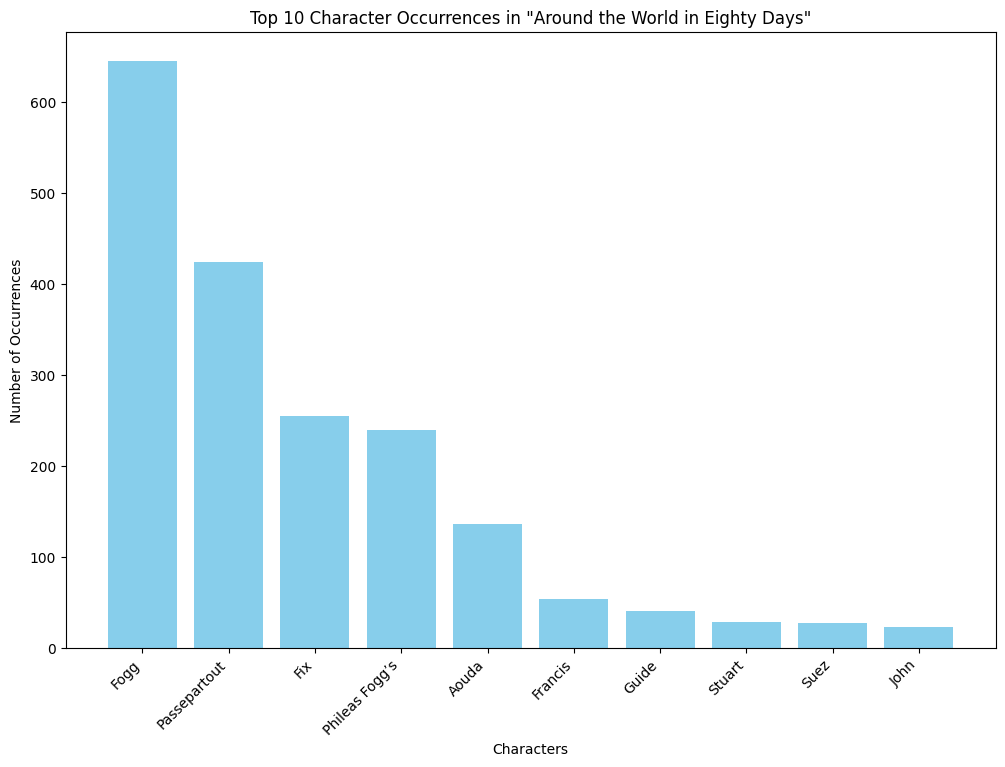

In [ ]:
number_locations = sorted(number_locations, key=lambda x: x[1], reverse=True)

# Select top 10 characters
top_10_locations = number_locations[:10]

# Extract characters and their counts
characters = [item[0] for item in top_10_locations]
counts = [item[1] for item in top_10_locations]

# Create bar graph
plt.figure(figsize=(12, 8))
plt.bar(characters, counts, color='skyblue')
plt.xlabel('Characters')
plt.ylabel('Number of Occurrences')
plt.title('Top 10 Character Occurrences in "Around the World in Eighty Days"')
plt.xticks(rotation=45, ha='right')  # Rotate the character names for better readability
plt.show()

Character with the most connections (largest number of arcs): Andrew Stuart with 8 connections


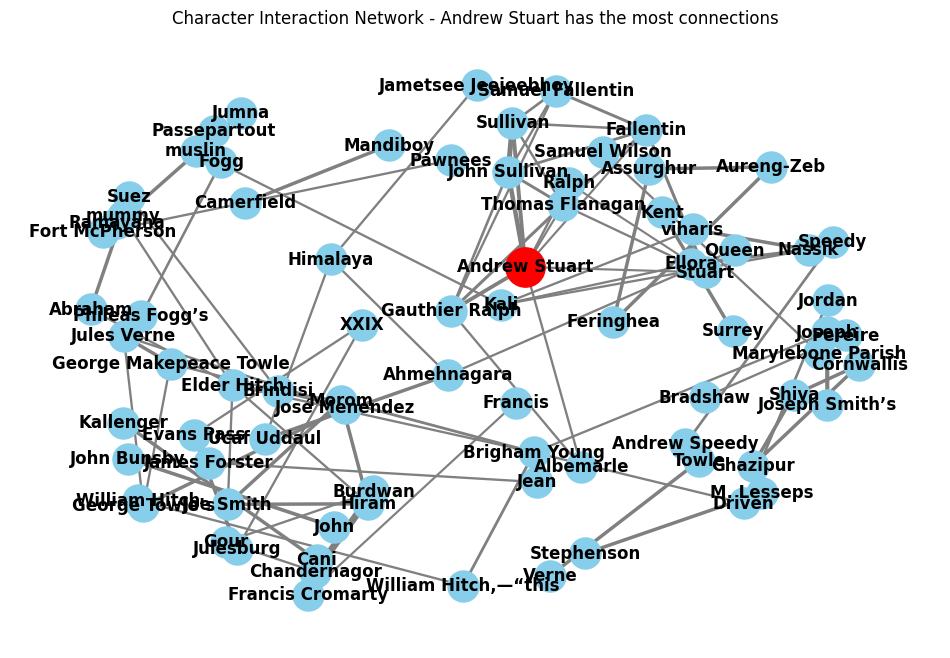

In [ ]:
G = nx.Graph()

# Add edges to the graph
for character1, character2, weight in filtered_connections:
    G.add_edge(character1, character2, weight=weight)
degree_dict = dict(G.degree())

# Find the character with the most connections
max_degree_character = max(degree_dict, key=degree_dict.get)
max_degree = degree_dict[max_degree_character]

# Print the result
print(f"Character with the most connections (largest number of arcs): {max_degree_character} with {max_degree} connections")

# Visualization (optional)
# Generate positions using the Spring Layout
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for spacing

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

# Draw edges with weights
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*5 for u, v in G.edges()])

# Highlight the node with the most connections in red
nx.draw_networkx_nodes(G, pos, nodelist=[max_degree_character], node_color='red', node_size=800)

# Show the plot
plt.title(f"Character Interaction Network - {max_degree_character} has the most connections")
plt.axis('off')
plt.show()

In [ ]:
num_nodes = G.number_of_nodes()
print(f"Number of nodes (characters): {num_nodes}")

# Print the number of arcs
num_edges = G.number_of_edges()
print(f"Number of arcs (connections): {num_edges}")

Number of nodes (characters): 80
Number of arcs (connections): 88


Character with the highest sum of connections: Andrew Stuart with a sum of 3.37


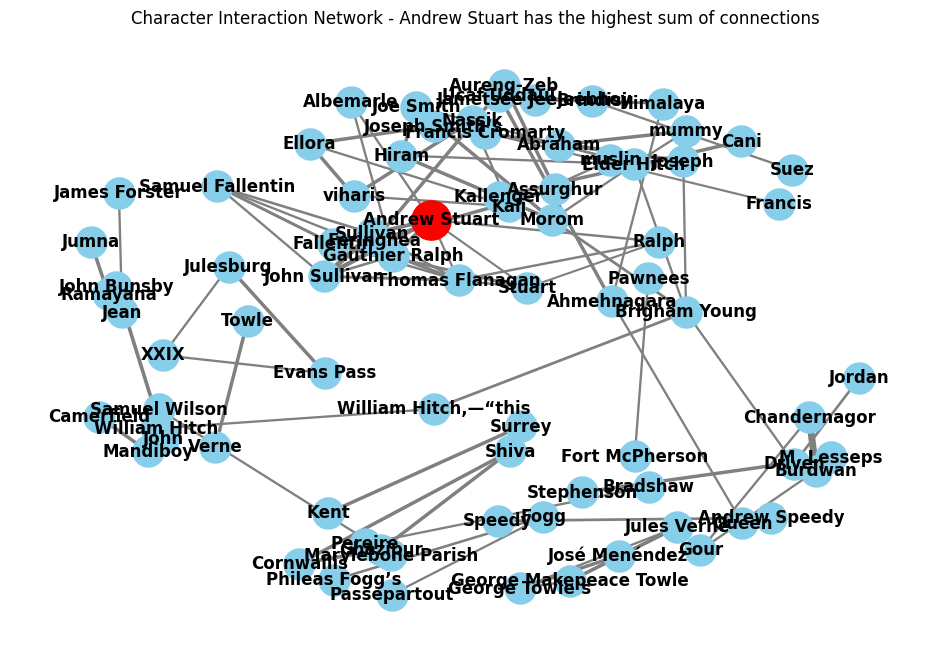

In [ ]:
connection_sums = {}
for character1, character2, data in G.edges(data=True):
    if character1 not in connection_sums:
        connection_sums[character1] = 0
    if character2 not in connection_sums:
        connection_sums[character2] = 0
    connection_sums[character1] += data['weight']
    connection_sums[character2] += data['weight']

# Find the character with the highest sum of connections
max_character = max(connection_sums, key=connection_sums.get)
max_sum = connection_sums[max_character]

# Print the result
print(f"Character with the highest sum of connections: {max_character} with a sum of {max_sum:.2f}")

# Visualization (optional)
# Generate positions using the Spring Layout
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for spacing

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

# Draw edges with weights
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*5 for u, v in G.edges()])

# Highlight the node with the highest sum of connections in red
nx.draw_networkx_nodes(G, pos, nodelist=[max_character], node_color='red', node_size=800)

# Show the plot
plt.title(f"Character Interaction Network - {max_character} has the highest sum of connections")
plt.axis('off')
plt.show()

***What are the social circles of the characters?***

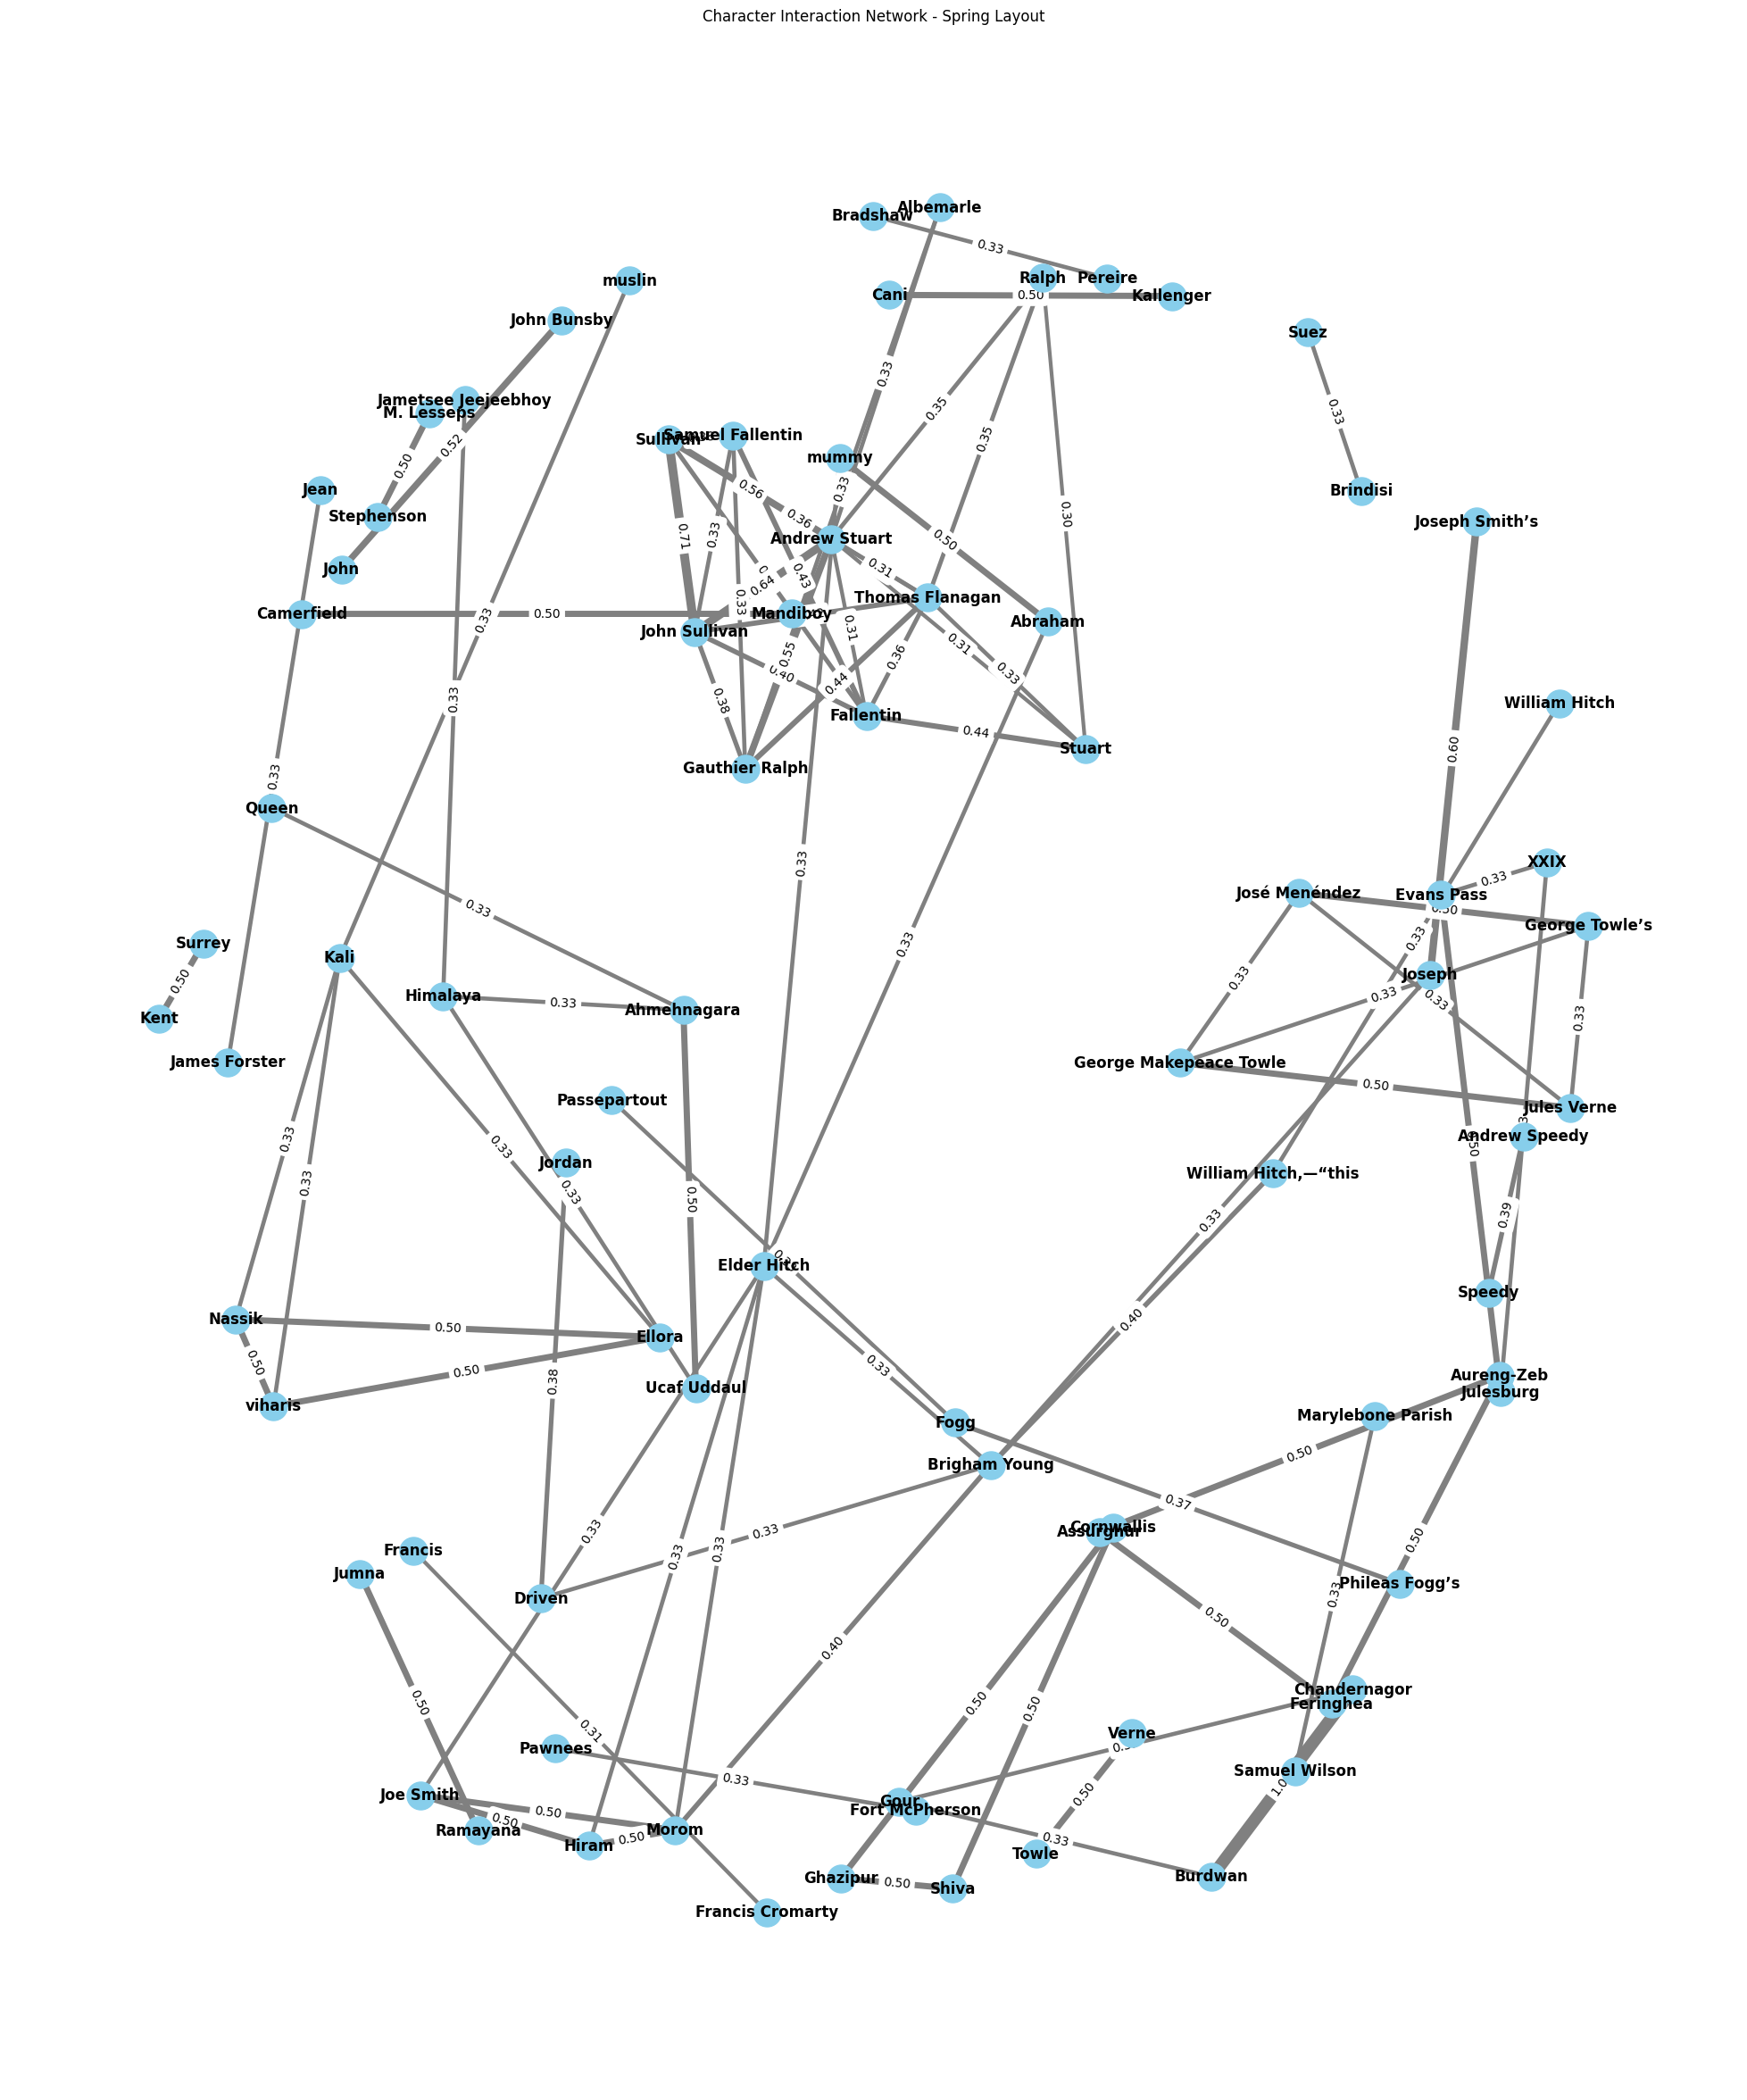

In [ ]:
# Create a graph
G = nx.Graph()

# Add edges to the graph
for character1, character2, weight in filtered_connections:
    G.add_edge(character1, character2, weight=weight)

# Generate positions using the Spring Layout
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust k for spacing

# Draw the graph
plt.figure(figsize=(25, 30))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

# Draw edges with weights
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*10 for u, v in G.edges()])

# Draw edge labels
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.title("Character Interaction Network - Spring Layout")
plt.axis('off')
plt.show()


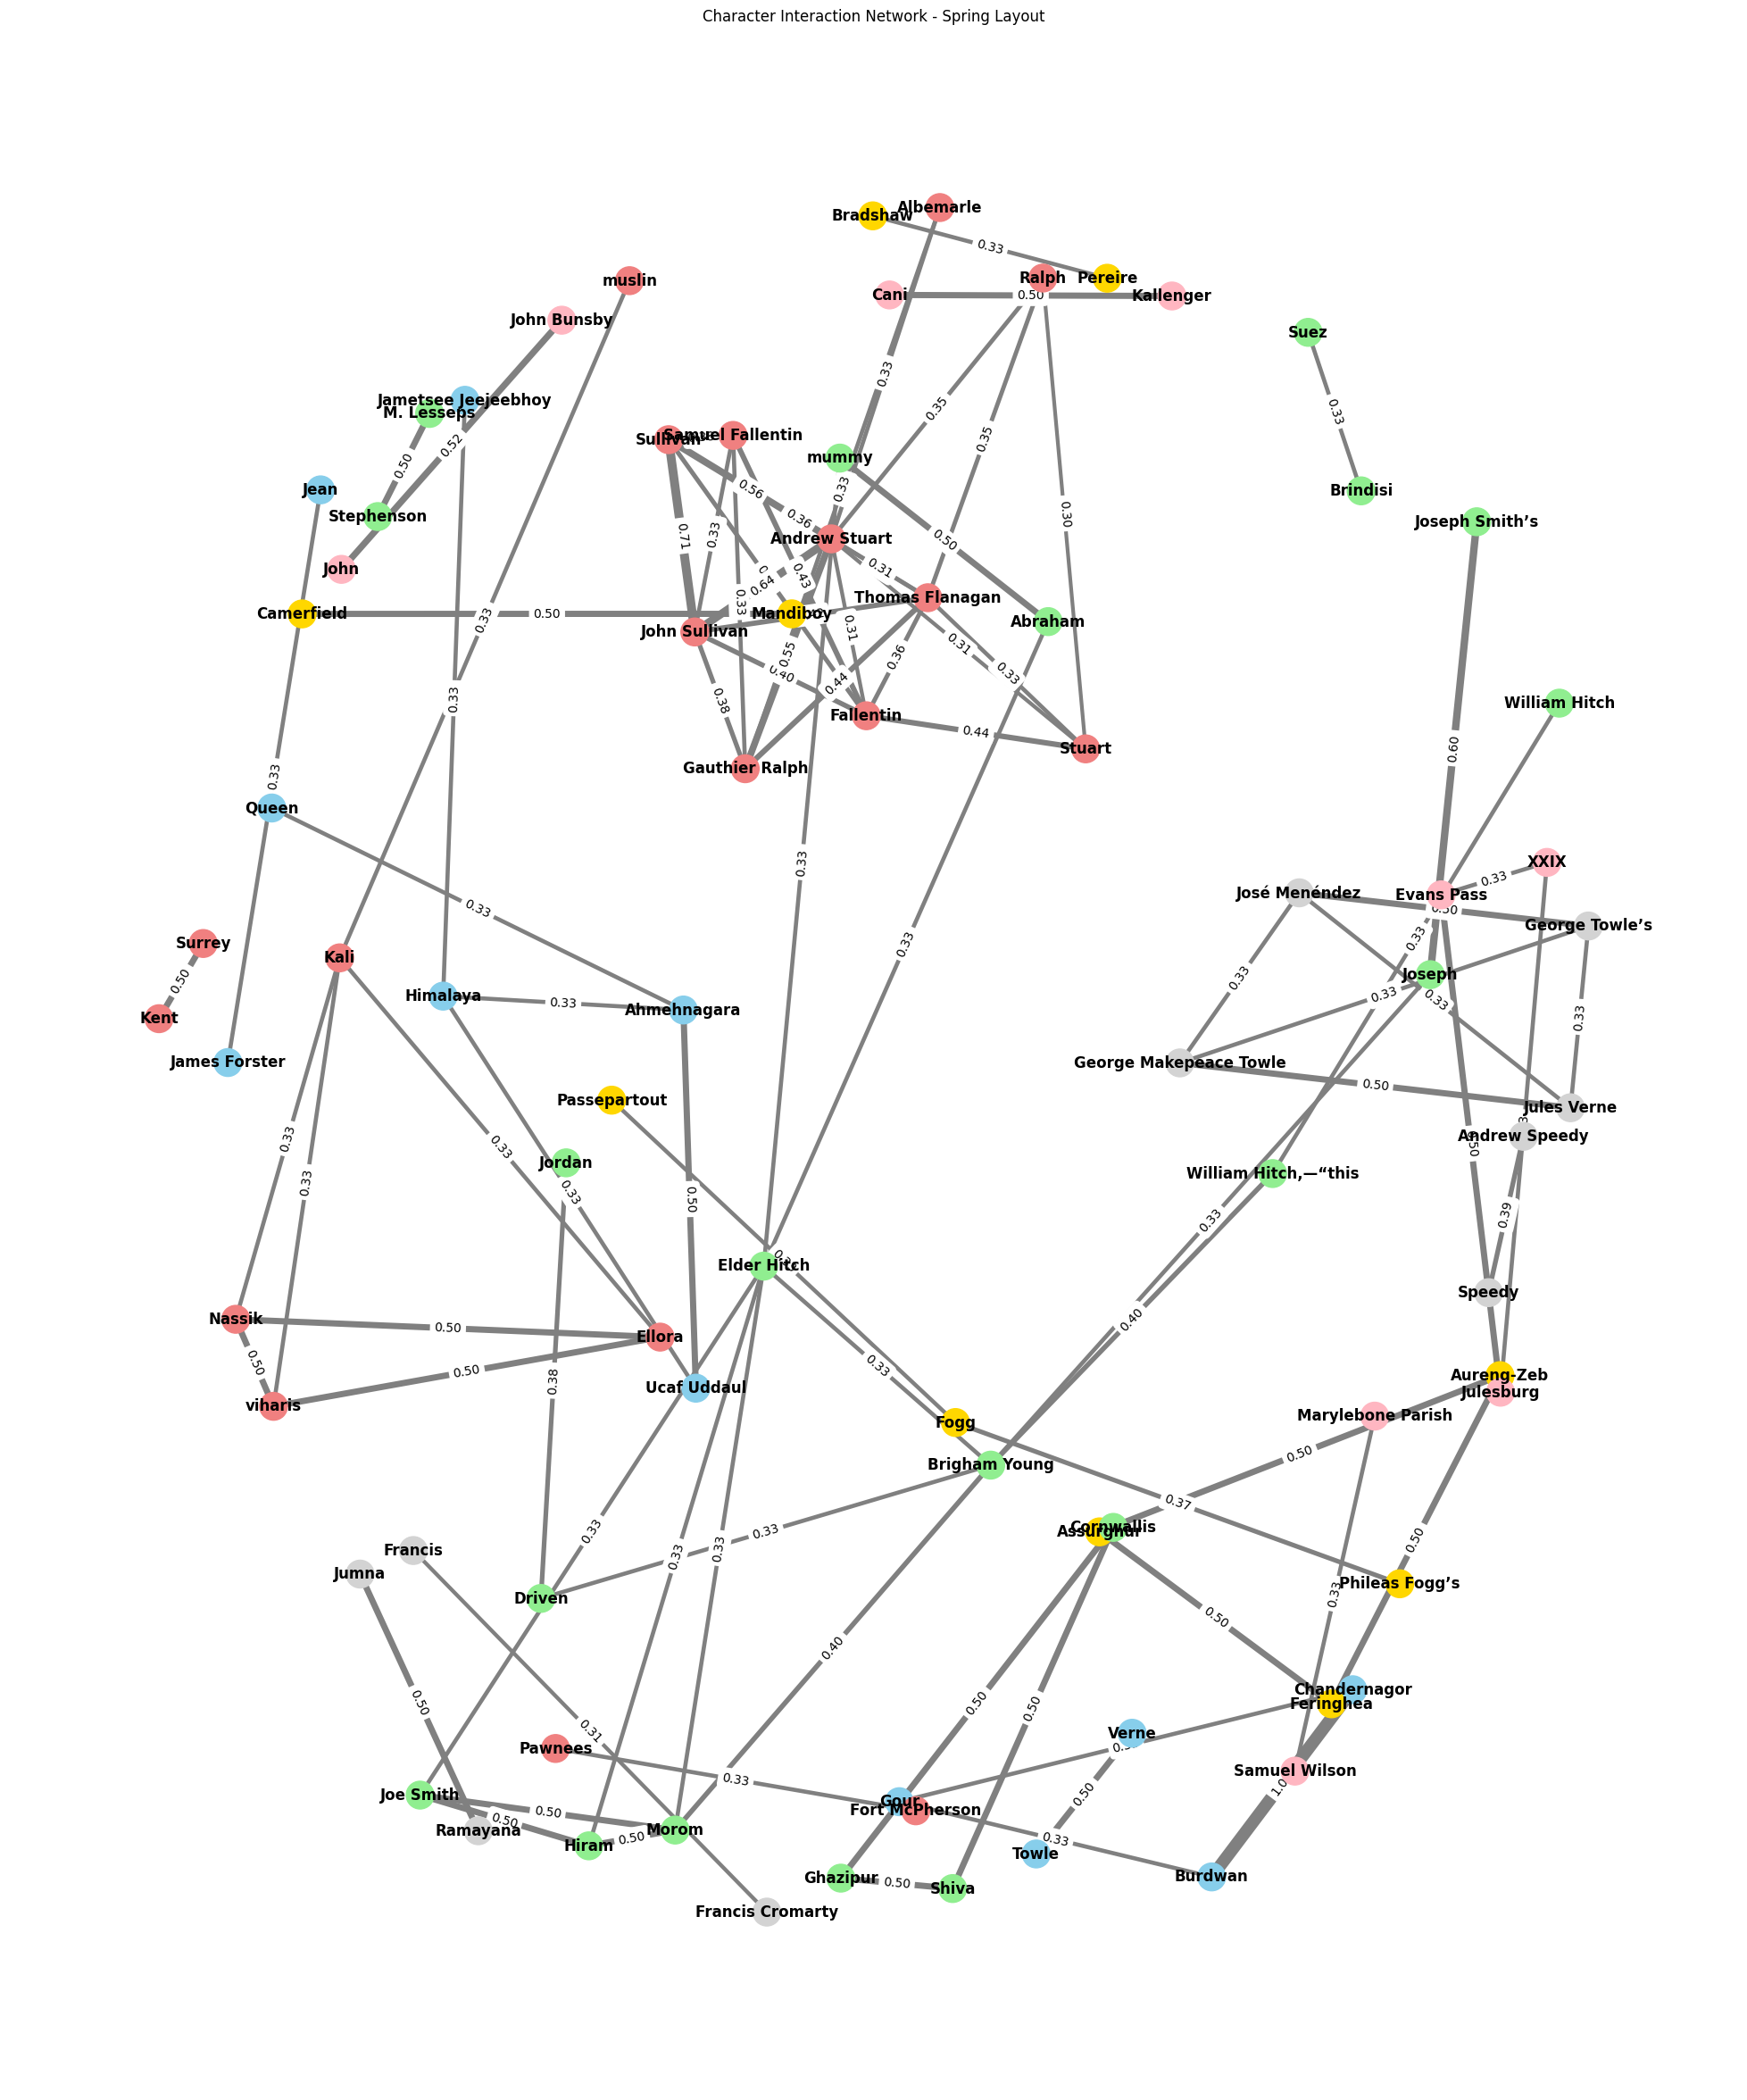

In [ ]:
from itertools import cycle

components = list(nx.connected_components(G))
component_colors = cycle(['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink', 'lightgray'])

color_map = {}
for color, component in zip(component_colors, components):
    for node in component:
        color_map[node] = color

# Draw the graph
plt.figure(figsize=(25, 30))
nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

# Draw edges with weights
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*10 for u, v in G.edges()])

# Draw edge labels
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.title("Character Interaction Network - Spring Layout")
plt.axis('off')
plt.show()


In [ ]:
print("Connected Components:")
for i, component in enumerate(components):
    print(f"Component {i+1}: {component}")

Connected Components:
Component 1: {'Gour', 'Burdwan', 'Chandernagor'}
Component 2: {'Brigham Young', 'mummy', 'Elder Hitch', 'Joe Smith', 'Abraham', 'William Hitch,—“this', 'William Hitch', 'Driven', 'Morom', 'Hiram', 'Joseph', 'Jordan', 'Joseph Smith’s'}
Component 3: {'Stuart', 'Fallentin', 'Samuel Fallentin', 'John Sullivan', 'Albemarle', 'Gauthier Ralph', 'Thomas Flanagan', 'Andrew Stuart', 'Ralph', 'Sullivan'}
Component 4: {'Phileas Fogg’s', 'Passepartout', 'Fogg'}
Component 5: {'John Bunsby', 'John'}
Component 6: {'George Towle’s', 'José Menéndez', 'George Makepeace Towle', 'Jules Verne'}
Component 7: {'Verne', 'Towle'}
Component 8: {'M. Lesseps', 'Stephenson'}
Component 9: {'Ellora', 'muslin', 'viharis', 'Kali', 'Nassik'}
Component 10: {'Feringhea', 'Assurghur', 'Aureng-Zeb'}
Component 11: {'Cani', 'Kallenger'}
Component 12: {'Jumna', 'Ramayana'}
Component 13: {'Ahmehnagara', 'Himalaya', 'Ucaf Uddaul', 'Queen', 'Jametsee Jeejeebhoy'}
Component 14: {'Ghazipur', 'Shiva', 'Cornwall

***What is the strength of the relationship between the characters?***

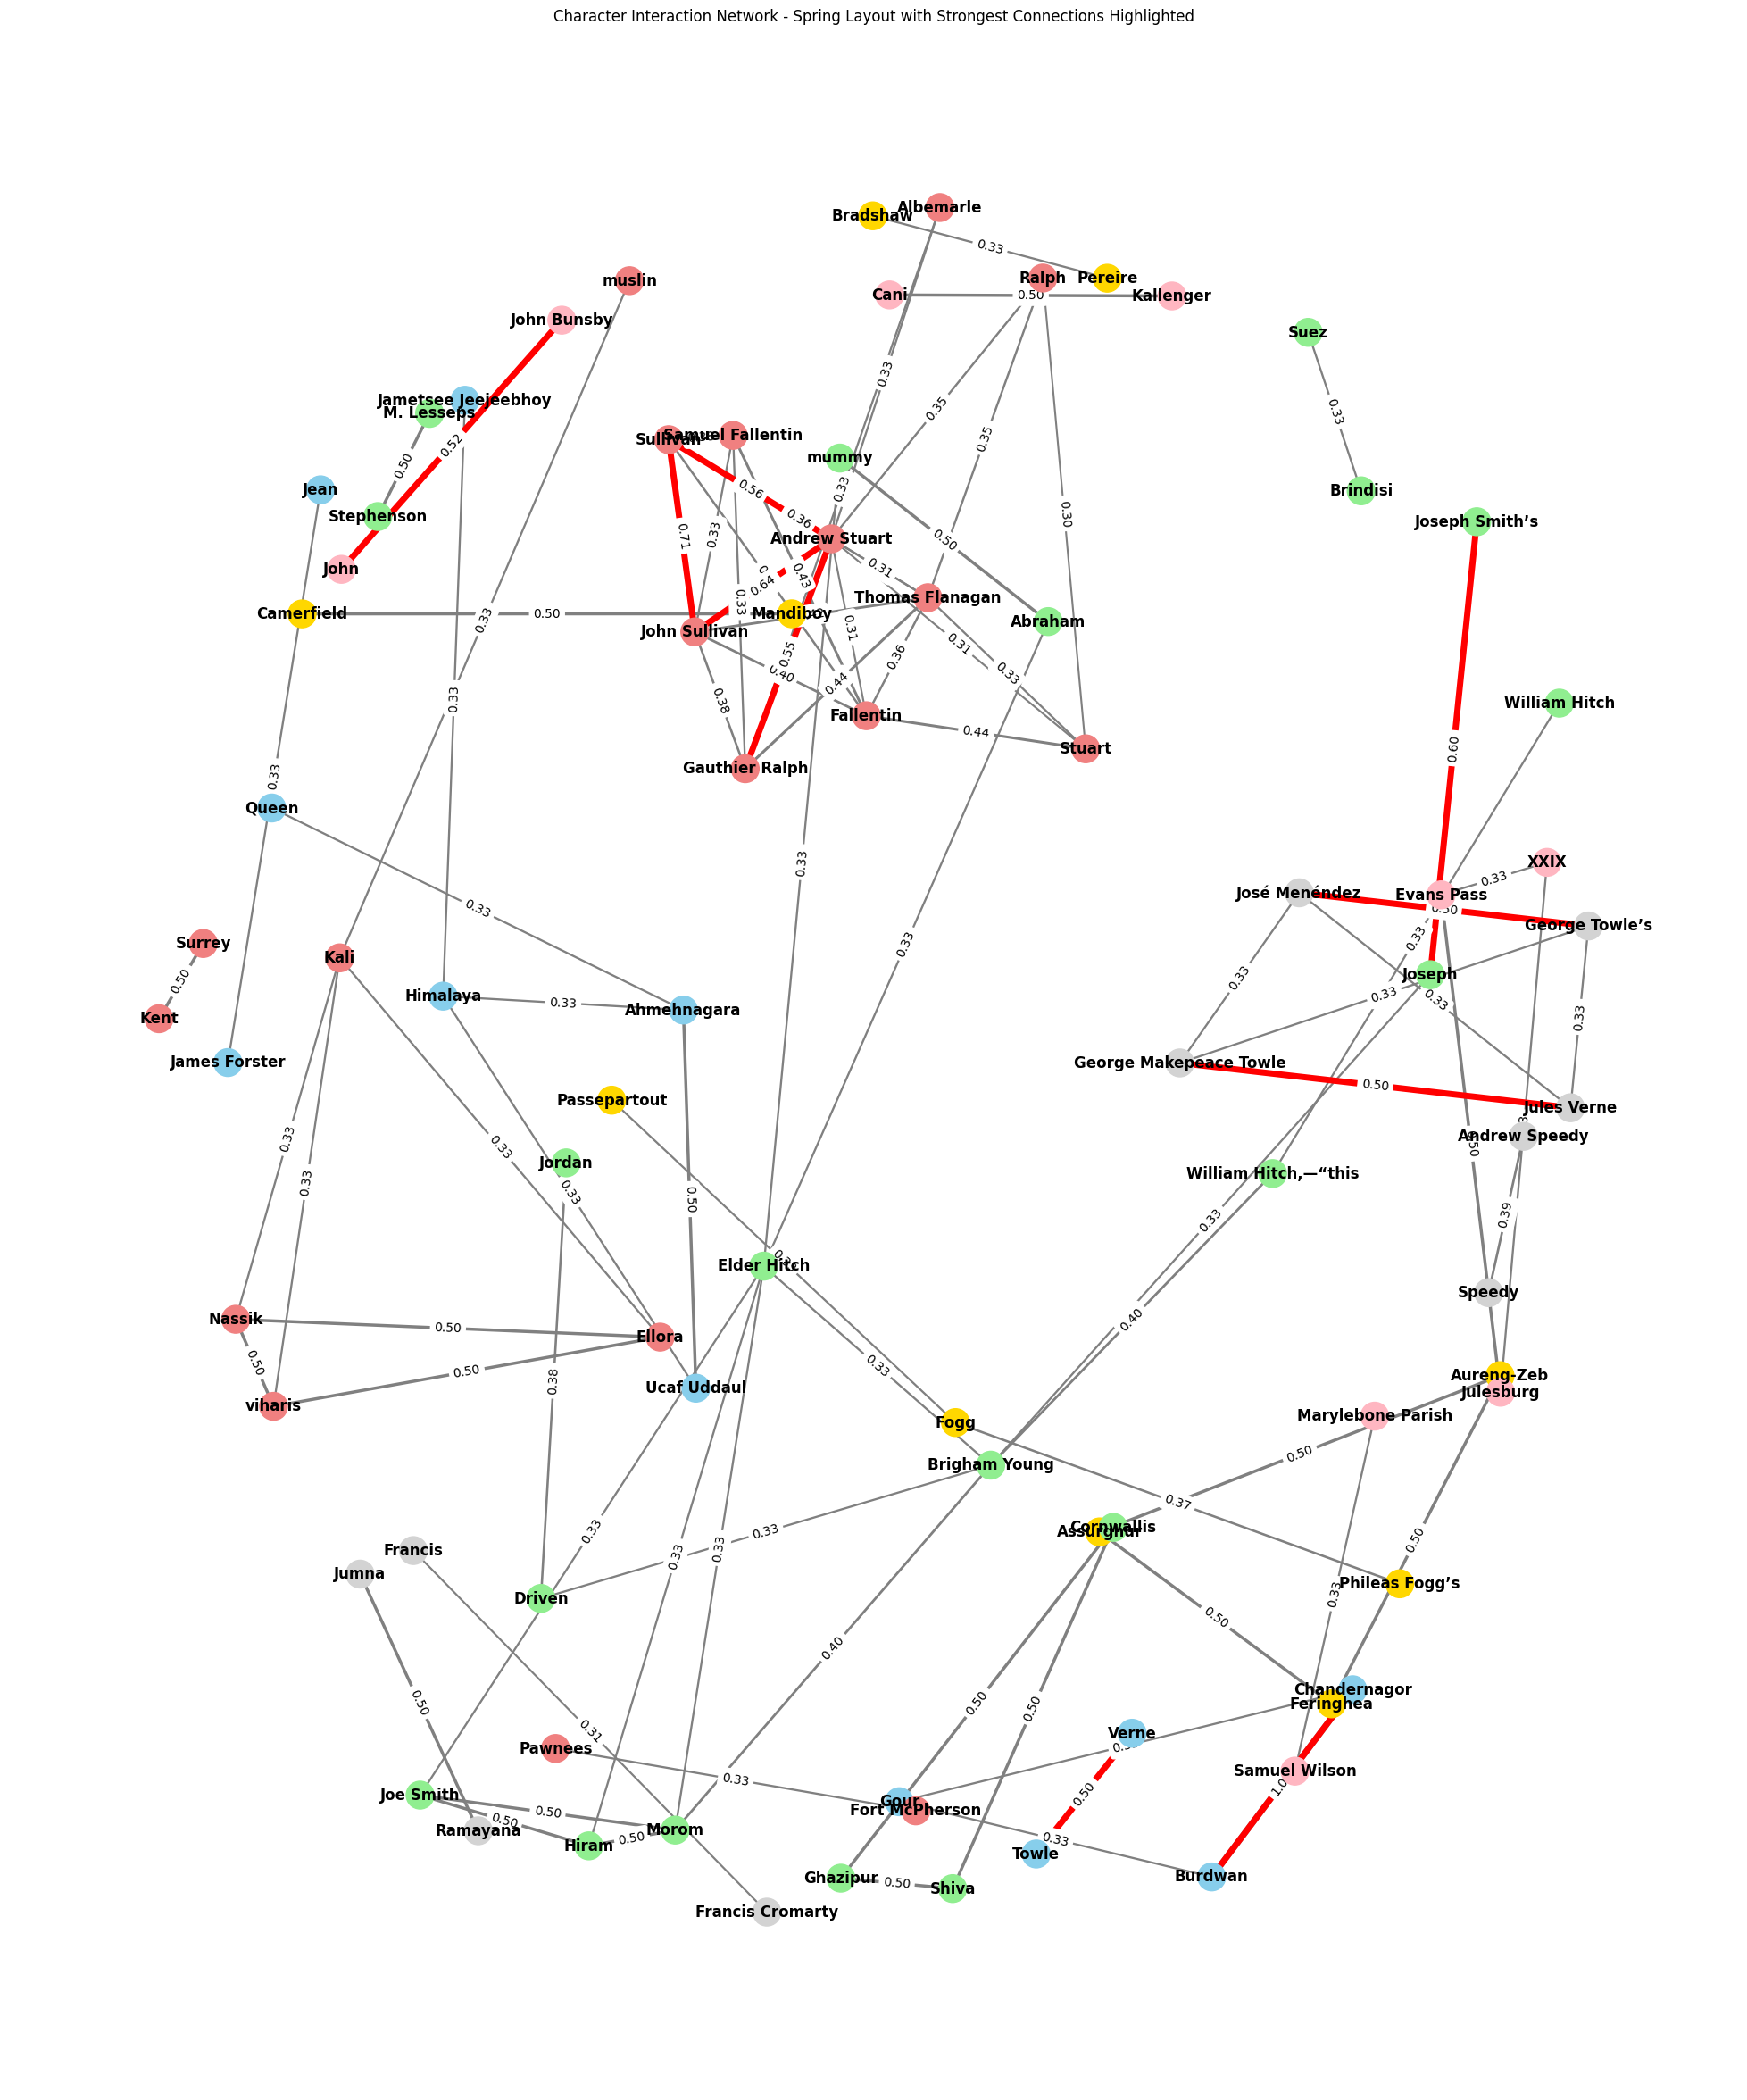

In [ ]:
strongest_connections = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

# Draw the graph
plt.figure(figsize=(25, 30))
nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=500)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_color='black')

# Draw edges with weights
all_edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*5 for u, v in G.edges()])

# Highlight the strongest connections in red
strongest_edges = nx.draw_networkx_edges(G, pos, edgelist=strongest_connections, edge_color='red', width=5)

# Draw edge labels
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.title("Character Interaction Network - Spring Layout with Strongest Connections Highlighted")
plt.axis('off')
plt.show()

In [ ]:
# Print the strongest connections
print("Strongest Connections:")
for connection in strongest_connections:
    character1, character2, data = connection
    print(f"{character1} - {character2}: {data['weight']:.2f}")

Strongest Connections:
Chandernagor - Burdwan: 1.00
Sullivan - John Sullivan: 0.71
John Sullivan - Andrew Stuart: 0.64
Joseph Smith’s - Joseph: 0.60
Sullivan - Andrew Stuart: 0.56
Andrew Stuart - Gauthier Ralph: 0.55
John Bunsby - John: 0.52
Jules Verne - George Makepeace Towle: 0.50
Verne - Towle: 0.50
George Towle’s - José Menéndez: 0.50


# **Part II - Real Characters**

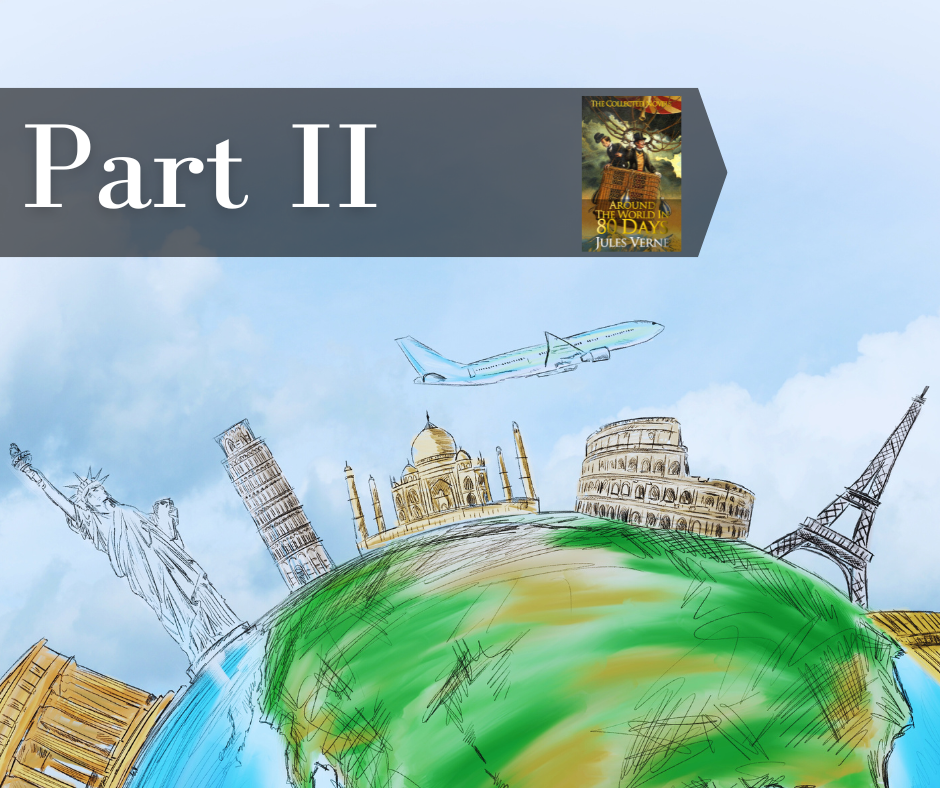

***Real Characters:***

In [ ]:
# Unification between the names of the characters, carried out with the help of ChatGPT:

real_characters_location = {
                          'Phileas Fogg': [(3, 6), (3, 11), (3, 12), (3, 23), (3, 26), (3, 28), (4, 6), (4, 15), (4, 19), (4, 27), (5, 5), (5, 14), (5, 16), (5, 17), (5, 19), (5, 21), (5, 22), (5, 24), (5, 26), (7, 7), (7, 12), (7, 23),  (8, 8), (8, 15), (8, 17), (9, 3), (9, 11), (9, 15), (10, 12), (10, 18), (10, 23), (10, 27), (10, 31), (11, 11), (11, 15), (11, 27), (11, 33), (12, 18), (12, 26), (12, 30), (13, 31), (14, 12), (14, 28), (14, 35), (15, 9), (15, 18), (15, 28), (16, 8), (16, 12), (16, 32), (17, 3), (17, 7), (17, 29), (19, 12), (19, 22), (19, 28), (19, 33), (20, 5), (20, 47), (21, 3), (21, 6), (21, 14), (21, 25), (21, 29), (21, 34), (22, 7), (22, 8), (22, 17), (22, 25), (22, 28), (23, 4), (23, 14), (24, 7), (24, 12), (24, 19), (24, 23), (25, 3), (25, 9), (25, 34), (25, 35), (26, 28), (26, 34), (27, 7), (27, 14), (27, 19), (27, 25), (27, 29), (28, 12), (28, 20), (28, 26), (28, 33), (29, 24), (29, 29),(30, 5), (30, 7), (30, 11), (30, 15), (30, 18), (30, 22), (30, 33), (31, 9), (32, 13), (38, 14), (38, 25), (38, 29), (39, 12), (40, 3), (42, 30), (43, 6), (43, 20), (43, 27), (46, 8), (47, 12), (48, 4), (49, 5), (50, 6), (50, 10), (50, 12), (51, 7), (51, 12), (53, 31), (54, 12), (54, 16), (54, 29), (54, 30), (55, 11), (55, 18), (56, 34), (57, 6), (57, 8), (58, 7), (58, 18), (58, 24), (59, 5), (59, 9), (59, 23), (59, 25), (59, 33), (59, 35), (60, 9), (61, 36), (62, 5), (62, 30), (63, 7), (63, 29), (63, 32), (64, 18), (64, 21), (64, 30), (65, 7), (65, 11), (65, 15), (65, 16), (65, 25), (65, 29), (66, 3), (66, 12), (66, 18), (66, 25), (67, 7), (67, 19), (68, 7), (68, 30), (68, 35), (69, 24), (69, 28), (70, 19), (72, 16), (72, 24), (72, 27), (74, 3), (74, 6), (74, 10), (75, 13), (75, 20), (75, 27), (75, 31), (76, 14), (77, 29), (79, 3), (79, 13), (79, 18), (79, 24), (79, 30), (80, 16), (80, 20), (80, 25), (80, 33), (81, 14), (81, 18), (81, 27), (82, 7), (82, 18), (83, 4), (83, 10), (83, 15), (85, 4), (85, 12), (85, 19), (85, 30), (86, 6), (86, 9), (86, 16), (86, 33), (86, 36), (88, 12), (88, 19), (89, 13), (89, 14), (89, 19), (89, 25), (89, 28), (89, 32), (90, 22), (90, 25), (91, 10), (91, 25), (91, 26), (91, 34), (92, 11), (92, 15), (93, 14), (93, 17), (93, 22), (93, 35), (94, 16), (94, 19), (94, 24), (94, 32), (95, 6), (95, 12), (95, 16), (95, 21), (95, 31), (96, 18), (97, 6), (97, 16), (97, 20), (98, 24), (99, 10), (99, 18), (99, 20), (99, 22), (99, 28), (99, 32), (100, 26), (100, 35), (102, 15), (102, 16), (102, 26), (102, 34), (103, 6), (103, 11), (103, 26), (103, 29), (104, 3), (104, 13), (104, 31), (105, 27), (106, 38), (106, 42), (107, 10), (107, 22), (108, 7), (108, 24), (109, 7), (110, 10), (110, 18), (110, 21), (110, 25), (110, 29), (110, 36), (111, 3), (111, 15), (111, 19), (111, 25), (111, 31), (112, 5), (112, 9), (112, 16), (112, 22), (114, 22), (115, 5), (117, 3), (117, 13), (117, 21), (118, 4), (118, 15), (118, 27), (118, 35), (119, 14), (119, 21), (120, 15), (121, 7), (121, 12), (121, 16), (121, 27), (122, 3), (122, 8), (122, 11), (122, 18), (122, 20), (123, 5), (123, 9), (123, 15), (123, 17), (123, 22), (124, 19), (124, 21), (124, 23), (124, 29), (124, 35), (125, 8), (125, 29), (125, 35), (126, 5), (126, 29), (126, 35), (127, 4), (127, 8), (128, 27), (128, 33), (129, 20), (129, 22),(129, 25), (130, 6), (130, 21), (131, 7), (131, 13), (131, 19), (131, 21), (131, 27), (132, 3), (132, 22), (132, 26), (133, 11), (133, 27), (134, 4), (134, 8), (134, 19), (135, 6), (135, 16), (135, 28), (136, 7), (136, 11), (136, 16), (137, 18), (137, 34), (138, 19), (138, 24), (138, 25), (138, 29), (138, 33), (139, 4), (139, 6), (139, 9), (139, 27), (139, 32), (140, 10), (151, 27), (151, 31), (151, 32), (152, 7), (152, 15), (152, 22), (152, 29), (153, 16), (153, 34), (154, 11), (154, 23), (154, 33), (155, 3), (156, 16), (156, 22), (156, 34), (157, 5), (157, 26), (157, 30), (158, 3), (158, 21), (159, 11), (159, 30), (161, 9), (161, 12), (161, 18), (161, 23), (161, 28), (161, 31), (162, 8), (162, 10), (162, 20), (163, 3), (163, 7), (163, 15), (163, 22), (163, 26), (163, 32), (163, 35), (164, 8), (164, 12), (164, 17), (164, 27), (164, 33), (165, 11), (165, 15),(165, 18), (165, 23), (165, 30), (165, 32), (166, 7), (167, 21), (170, 6), (170, 18), (170, 29),(171, 9),(173, 12), (176, 23), (180, 5), (180, 17), (180, 27), (180, 36), (181, 5), (181, 7), (181, 10), (181, 15), (181, 22), (181, 29), (182, 6), (182, 11), (182, 13), (182, 25), (182, 32), (183, 31), (184, 3), (185, 19), (188, 25), (189, 24), (189, 28), (189, 34), (190, 3), (190, 7), (190, 14), (190, 19), (190, 25), (190, 31), (190, 34), (191, 3), (191, 7), (191, 14), (191, 25), (191, 29), (191, 33), (192, 3), (192, 6), (192, 27), (193, 8), (193, 22), (194, 28), (194, 31), (194, 34), (196, 7), (196, 22), (196, 32), (197, 5), (197, 7), (197, 8), (197, 16), (197, 25), (197, 32), (198, 9), (198, 17), (198, 21), (198, 30), (198, 36), (199, 17), (202, 17), (202, 29), (203, 5), (203, 9), (203, 19), (204, 8), (204, 12), (204, 15), (205, 3), (205, 8), (205, 10), (205, 11), (205, 13), (205, 27), (205, 30), (205, 36), (206, 6), (206, 10), (206, 14), (207, 8), (207, 21), (207, 29), (208, 11), (208, 12), (209, 11), (209, 12), (209, 19), (209, 32), (211, 7), (211, 13), (211, 19), (211, 22), (211, 32), (211, 33), (212, 8), (212, 14), (212, 18), (212, 27), (212, 34), (213, 6), (213, 8), (213, 35), (214, 9), (214, 17), (214, 33), (215, 3), (215, 11),  (216, 7), (216, 20), (216, 23), (216, 25), (216, 30), (216, 33), (217, 5), (217, 15), (218, 3), (218, 8), (218, 16), (218, 25), (218, 35), (219, 15), (219, 24), (219, 35), (220, 18), (220, 27), (220, 29), (221, 8), (221, 12), (221, 22), (221, 29), (222, 6), (222, 10), (222, 18), (222, 19), (222, 22), (223, 5), (223, 10), (223, 12), (223, 17), (223, 25), (223, 32), (223, 36), (224, 5), (224, 10), (224, 14), (224, 15), (225, 7), (225, 11), (225, 18), (225, 22), (225, 23), (225, 27), (226, 5), (226, 14), (226, 24), (226, 28), (227, 5), (227, 14), (227, 21), (227, 29), (227, 32), (227, 35), (228, 6), (228, 12), (229, 7), (229, 14), (229, 17), (230, 3), (230, 7), (230, 19), (230, 22), (230, 33), (231, 4), (231, 6), (231, 13), (231, 22), (231, 26), (231, 34), (232, 9), (232, 16), (232, 19), (232, 21), (232, 26), (232, 28), (232, 33), (233, 6), (233, 11), (233, 22), (233, 27), (233, 30), (234, 7), (234, 10), (234, 16), (235, 7), (235, 16), (235, 22), (235, 24), (235, 26), (235, 30), (236, 7), (236, 12), (236, 22), (236, 24), (236, 31), (237, 9), (237, 12), (237, 17), (237, 28), (237, 34), (238, 33), (239, 7), (239, 13), (239, 29), (239, 31), (240, 6), (240, 14), (240, 20), (240, 22), (240, 30), (241, 7), (241, 11), (241, 15), (241, 24), (241, 26), (241, 32), (241, 33), (242, 6), (242, 12), (242, 15), (242, 16)],
                          'Passepartout': [(3, 6), (3, 8), (3, 12), (3, 20), (3, 24), (4, 4), (4, 15), (4, 17), (4, 22), (4, 25), (5, 7), (5, 10), (5, 23), (7, 7), (10, 34), (11, 14), (11, 15), (11, 25), (11, 36), (11, 45), (12, 7), (12, 12), (12, 18), (13, 14), (13, 17), (13, 28), (13, 30), (13, 34), (14, 9), (14, 18), (14, 23), (14, 30), (15, 22), (24, 7), (24, 14), (24, 20), (24, 21), (24, 23), (24, 25), (24, 31), (25, 5), (25, 11), (25, 18), (25, 24), (25, 31), (26, 12), (26, 15), (26, 20), (26, 31), (27, 20), (27, 24), (38, 18), (39, 11), (39, 13), (41, 7), (41, 12), (41, 17), (41, 27), (42, 9), (42, 13), (43, 22), (43, 29), (44, 9), (44, 11), (44, 29), (48, 6), (48, 21), (49, 11), (49, 16), (49, 20), (49, 25), (50, 13), (50, 21), (50, 31), (52, 7), (55, 10), (55, 13), (55, 36), (56, 18), (56, 31), (57, 3), (57, 8), (58, 15), (60, 3), (60, 20), (61, 15), (61, 21), (62, 16), (62, 22), (62, 35), (63, 3), (63, 26), (64, 22), (65, 20), (66, 5), (66, 8), (66, 20), (66, 25), (67, 25), (68, 10), (68, 28), (68, 36), (69, 22), (70, 19), (71, 17), (72, 22), (73, 3), (75, 7), (75, 17), (78, 30), (78, 34), (79, 12), (79, 34), (81, 15), (81, 19), (81, 22), (82, 14), (82, 17), (82, 20), (83, 19), (83, 22), (83, 30), (83, 33), (85, 6), (85, 21), (85, 26), (85, 27), (85, 31), (86, 8), (86, 9), (86, 28), (87, 4), (88, 8), (89, 12), (89, 22), (89, 27), (89, 32), (90, 19), (90, 31), (90, 35), (91, 21), (91, 27), (91, 28), (91, 31), (92, 7), (92, 22), (92, 28), (92, 34), (93, 7), (93, 22), (93, 26), (93, 31), (94, 5), (94, 7), (94, 9), (94, 20), (94, 33), (95, 8), (95, 13), (97, 3), (98, 10), (98, 14), (99, 8), (99, 9), (99, 15), (100, 5), (100, 11), (100, 16), (100, 21), (100, 32), (101, 3), (101, 13), (102, 12), (102, 19), (102, 27), (102, 31), (103, 4), (103, 14), (103, 31), (104, 18), (105, 17), (105, 18), (105, 33), (105, 36), (106, 5), (106, 24), (106, 29), (106, 41), (107, 4), (107, 9), (107, 16), (107, 20), (107, 25), (107, 30), (108, 7), (109, 14), (109, 19), (109, 24), (109, 26), (109, 34), (110, 5), (110, 14), (110, 20), (110, 26), (111, 5), (112, 7), (112, 27), (112, 30), (113, 7), (113, 25), (114, 4), (114, 9), (114, 15), (114, 24), (114, 27), (114, 36), (115, 4), (115, 19), (115, 34), (115, 35), (116, 8), (116, 15), (116, 19), (116, 23), (116, 25), (116, 33), (117, 7), (117, 11), (117, 24), (117, 29), (118, 6), (118, 10), (118, 19), (118, 24), (119, 3), (119, 12), (119, 16), (119, 28), (120, 7), (120, 11), (120, 14), (121, 34), (125, 33), (126, 5), (127, 10), (129, 36), (130, 6), (137, 7), (137, 22), (137, 24), (138, 6), (138, 11), (138, 35), (139, 7), (139, 10), (139, 15), (139, 21), (139, 34), (140, 3), (140, 24), (141, 15), (141, 34), (142, 18), (143, 12), (143, 31), (144, 10), (144, 15), (145, 7), (145, 11), (145, 24), (145, 32), (146, 3), (146, 25), (147, 12), (147, 26), (147, 28), (147, 30), (148, 16), (148, 27), (148, 31), (148, 36), (149, 9), (150, 36), (151, 20), (151, 27), (151, 33), (152, 25), (152, 28), (152, 34), (153, 7), (153, 10), (154, 20), (155, 20), (155, 29), (155, 34), (156, 8), (156, 10), (156, 35), (157, 6), (157, 13), (157, 21), (157, 27), (157, 36), (158, 11), (158, 14), (159, 12), (159, 22), (160, 5), (160, 7), (160, 13), (160, 32), (161, 8), (161, 14), (165, 3), (168, 12), (168, 16), (171, 5), (172, 7), (172, 16), (172, 19), (172, 30), (173, 5), (173, 11), (174, 32), (175, 7), (175, 27), (177, 30), (178, 18), (178, 23), (179, 7), (180, 3), (180, 15), (181, 8), (181, 13), (181, 23), (181, 30), (182, 3), (182, 27), (182, 35), (183, 32), (184, 6), (184, 16), (184, 27), (184, 34), (185, 11), (185, 21), (185, 30), (185, 36), (186, 12), (186, 21), (186, 25), (186, 30), (187, 11), (187, 18), (190, 19), (190, 33), (192, 8), (192, 28), (193, 15), (194, 33), (196, 13), (196, 24), (202, 30), (202, 34), (203, 7), (203, 13), (204, 13), (206, 3), (206, 6), (207, 33), (208, 6), (208, 10), (208, 26), (209, 10), (209, 13), (209, 21), (211, 25), (212, 18), (214, 36), (215, 6), (217, 4), (217, 22), (218, 14), (218, 33), (219, 19), (219, 25), (220, 3), (220, 12), (220, 30), (222, 3), (222, 33), (225, 14), (225, 17), (225, 24), (225, 32), (227, 12), (227, 15), (227, 26), (227, 30), (229, 8), (229, 17), (230, 11), (230, 20), (230, 28), (231, 3), (231, 8), (231, 36), (232, 10), (234, 6), (234, 7), (234, 12), (234, 19), (239, 17), (239, 20), (239, 22), (239, 35), (240, 9), (240, 12), (241, 12), (241, 19), (241, 21), (241, 35), (242, 5), (242, 7)],
                          'George Towle:': [(1, 9), (2, 9), (2, 12), (62, 34), (104, 35), (111, 35), (122, 36), (135, 34), (137, 32), (160, 35)],
                          'James Forster': [(10, 14), (10, 28), (11, 40), (185, 24), (185, 33)],
                          'Andrew Stuart': [(17, 7), (17, 15), (17, 21), (19, 8), (19, 11), (19, 15), (19, 24), (19, 33), (19, 34), (20, 43), (20, 50), (21, 5), (21, 8), (21, 22), (21, 27), (21, 31), (21, 33), (22, 23), (22, 27), (27, 11), (236, 26), (236, 30), (236, 35), (237, 8), (237, 15), (237, 24), (238, 3), (238, 8), (238, 24)],
                          'John Sullivan': [(17, 8), (20, 6), (22, 3), (22, 23), (236, 25), (237, 21), (238, 21)],
                          'Francis Cromarty': [(58, 17), (58, 19), (58, 32), (59, 9), (59, 23), (59, 24), (59, 28), (59, 35), (60, 9), (62, 11), (62, 16), (62, 30), (63, 5), (63, 10), (63, 22), (63, 26), (63, 29), (63, 33), (64, 18), (65, 29), (66, 21), (66, 24), (67, 19), (68, 7), (69, 21), (70, 12), (71, 15), (72, 9), (72, 16), (72, 32), (73, 5), (73, 21), (73, 27), (74, 4), (75, 15), (75, 24), (77, 29), (79, 3), (79, 11), (79, 16), (79, 20), (79, 24), (79, 30), (80, 16), (80, 19), (80, 32), (81, 14), (81, 17), (82, 15), (82, 33), (85, 30), (86, 5), (86, 31), (87, 3)],
                          'Aouda': [(76, 8), (83, 5), (84, 7), (84, 31), (85, 31), (86, 11), (86, 16), (87, 3), (89, 16), (89, 32), (90, 21), (90, 30), (95, 12), (96, 17), (96, 23), (96, 29), (96, 34), (97, 8), (97, 13), (97, 18), (99, 17), (100, 32), (102, 17), (103, 27), (104, 3), (104, 12), (104, 23), (107, 16), (107, 21), (108, 31), (111, 32), (112, 8), (112, 17), (112, 20), (119, 14), (121, 13), (121, 26), (122, 5), (122, 8), (122, 15), (122, 23), (122, 26), (123, 12), (124, 19), (125, 33), (126, 29), (127, 8), (130, 10), (130, 21), (131, 7), (133, 11), (133, 25), (134, 18), (139, 3), (139, 4), (139, 28), (140, 10), (151, 27), (151, 33), (152, 19), (152, 23), (153, 7), (154, 17), (154, 24), (156, 34), (159, 11), (160, 4), (161, 9), (161, 12), (163, 7), (163, 33), (164, 24), (164, 36), (165, 5), (180, 22), (180, 25), (181, 7), (181, 15), (181, 31), (182, 21), (182, 30), (184, 3), (189, 34), (190, 18), (190, 31), (191, 34), (192, 9), (194, 14), (196, 22), (196, 25), (196, 33), (197, 4), (198, 12), (198, 28), (199, 15), (200, 24), (201, 5), (201, 24), (202, 7), (203, 11), (205, 35), (206, 5), (207, 31), (212, 9), (212, 19), (214, 36), (217, 3), (225, 16), (226, 3), (227, 15), (227, 29), (228, 8), (230, 6), (230, 20), (230, 23), (230, 24), (231, 8), (231, 12), (231, 19), (232, 13), (232, 15), (232, 17), (232, 20), (232, 24), (232, 26), (232, 33), (233, 6), (233, 17), (233, 27), (233, 32), (234, 5), (234, 7), (234, 17), (241, 25), (241, 33), (242, 14)],
                          'William Hitch': [(172, 31), (173, 13), (173, 29), (174, 9), (175, 16)],
                          'Joseph Smith': [(173, 15), (173, 34), (174, 3), (174, 24), (175, 9), (208, 20)],
                          'Thomas Flanagan': [(17, 9), (17, 13), (19, 23), (236, 27), (237, 4), (237, 17), (238, 14)],
                          'Detective Fix': [(3, 16), (4, 11), (4, 15), (4, 19), (5, 15), (30, 35), (32, 7), (33, 7), (33, 20), (33, 29), (34, 5), (34, 10), (34, 20), (34, 32), (35, 10), (35, 19), (35, 24), (35, 34), (36, 5), (36, 20), (36, 24), (37, 19), (38, 8), (38, 12), (39, 7), (39, 11), (42, 19), (42, 27), (42, 30), (42, 34), (43, 21), (43, 26), (44, 9), (44, 12), (44, 15), (44, 22), (45, 7), (48, 20), (48, 21), (48, 28), (48, 33), (49, 5), (49, 14), (49, 16), (49, 21), (50, 11), (50, 33), (54, 29), (54, 36), (55, 6), (56, 34), (57, 5), (57, 9), (62, 18), (93, 6), (93, 13), (93, 16), (93, 20), (94, 18), (94, 29), (95, 13), (95, 22), (96, 7), (98, 7), (98, 25), (98, 32), (99, 7), (99, 23), (99, 35), (100, 7), (100, 10), (100, 15), (100, 19), (100, 28), (100, 36), (101, 11), (101, 14), (102, 13), (102, 20), (102, 27), (102, 28), (103, 5), (103, 6), (103, 17), (103, 29), (103, 31), (105, 24), (105, 31), (105, 34), (106, 7), (106, 9), (106, 16), (106, 26), (106, 31), (106, 36), (107, 4), (107, 9), (108, 7), (109, 3), (109, 22), (110, 17), (110, 27), (114, 12), (114, 16), (114, 24), (114, 26), (115, 3), (115, 19), (115, 34), (116, 3), (116, 6), (116, 8), (116, 12), (116, 13), (116, 20), (116, 23), (116, 31), (116, 35), (117, 3), (117, 7), (117, 28), (117, 30), (117, 33), (118, 12), (118, 17), (118, 25), (118, 27), (119, 21), (119, 30), (120, 4), (120, 8), (120, 10), (120, 14), (120, 18), (121, 7), (122, 17), (122, 24), (123, 5), (123, 13), (123, 21), (124, 17), (124, 31), (124, 34), (125, 29), (126, 3), (126, 30), (126, 35), (127, 10), (129, 18), (129, 32), (130, 4), (130, 22), (131, 8), (131, 23), (133, 11), (133, 24), (137, 23), (138, 16), (138, 21), (138, 27), (139, 34), (152, 19), (153, 9), (155, 17), (155, 27), (156, 7), (156, 13), (156, 20), (156, 24), (157, 14), (157, 21), (157, 24), (157, 29), (158, 3), (158, 11), (161, 21), (161, 24), (162, 7), (162, 12), (162, 34), (163, 8), (163, 21), (163, 33), (163, 35), (164, 9), (164, 19), (164, 25), (164, 29), (164, 33), (165, 4), (165, 7), (165, 11), (168, 15), (173, 12), (180, 4), (181, 8), (181, 9), (181, 15), (181, 20), (181, 33), (182, 14), (184, 3), (189, 26), (189, 34), (190, 21), (190, 25), (191, 35), (192, 7), (193, 15), (196, 23), (197, 33), (198, 10), (198, 17), (198, 33), (199, 10), (199, 21), (201, 6), (201, 23), (202, 12), (203, 9), (203, 17), (204, 7), (204, 19), (204, 33), (205, 4), (205, 6), (205, 8), (206, 8), (206, 13), (208, 7), (209, 10), (214, 36), (215, 9), (217, 33), (217, 35), (218, 6), (220, 6), (220, 14), (222, 4), (223, 35), (224, 13), (225, 15), (225, 22), (225, 25), (225, 26), (225, 28), (225, 29), (227, 13), (227, 16), (227, 17), (227, 25), (227, 28), (230, 34), (232, 7), (232, 8), (236, 10), (241, 20)],
                          'John Bunsby’s': [(125, 25), (126, 17), (126, 23), (126, 25), (127, 17), (128, 21), (132, 20), (132, 30), (132, 31), (133, 8), (133, 34), (136, 5)],
                          'Queen': [(7, 30), (84, 11), (223, 5), (223, 11), (223, 13), (223, 20), (223, 30), (224, 17)],
                          'Andrew Speedy': [(132, 15), (213, 9), (214, 25), (214, 30), (216, 19), (216, 20), (216, 31), (218, 13), (220, 31), (220, 35), (221, 9), (221, 19), (221, 24), (221, 35), (222, 9), (222, 15), (223, 9), (223, 33)],
                          'Lincoln': [(7, 28), (166, 33)],
                          'José Menéndez': [(2, 24)],
                          'Abraham': [(174, 20)],
                          'Obadiah': [(90, 17), (91, 12), (91, 24), (92, 26), (93, 25), (93, 31)],
                          'Parbleu': [(90, 36), (116, 25), (117, 35), (171, 9), (227, 26)],
                          'Dutchmen': [(140, 34)],
                          'Sandy Hook': [(216, 14)],
                          'Samuel Wilson': [(234, 11), (239, 18), (241, 30)],
                          'Camerfield': [(162, 5), (163, 5), (163, 20), (163, 32), (164, 34)],
                          'Mandiboy': [(162, 6), (163, 6), (163, 19), (163, 30), (164, 35)],
                          'Marylebone Parish': [(234, 11)],
                          'Shiva': [(87, 16)],
                          'James Strand': [(235, 14), (235, 29), (235, 29)],
                          'De la Mer': [(176, 33)],
                          'Muddy Creek': [(179, 32)],
                          'Medicine Bow': [(184, 17), (184, 33), (184, 36), (187, 35)],
                          'Medicine Creek': [(186, 13)],
                          'Fort McPherson': [(189, 14)],
                          'John Bull': [(190, 16)],
                          'Oysterpuff': [(91, 18), (91, 25)],
                          'Jean': [(10, 33), (10, 34)],
                          'Angelica Kauffmann': [(12, 27)],
                          'Lord Albemarle': [(30, 14), (236, 15), (237, 31)],
                          'Stamp Proctor': [(164, 18), (165, 12), (180, 26), (181, 4), (181, 9), (181, 18), (184, 8), (184, 14), (184, 29), (186, 4), (186, 27), (187, 3), (189, 35), (190, 3), (190, 10), (190, 22), (191, 6), (191, 16), (192, 10), (193, 8), (193, 22), (196, 18), (201, 15)] + [(164, 18), (180, 26), (184, 8), (190, 3), (191, 16)]
                          }


In [ ]:
#Connections between the characters:

character_names = list(real_characters_location.keys())

# Grouping similar names
grouped_names = group_similar_names(character_names)

# Creating a combined dictionary with canonical names as keys
combined_character_locations = {}
for canonical_name, aliases in grouped_names.items():
    combined_character_locations[canonical_name] = []
    for alias in aliases:
        if alias in real_characters_location:
            combined_character_locations[canonical_name].extend(real_characters_location[alias])

# Calculate connections
connections = calculate_connections(combined_character_locations)

# Filter connections based on a threshold value
filtered_connections = [(x, y, z) for x, y, z in connections if z > 0.01]

# Sort connections based on strength
filtered_connections = sorted(filtered_connections, key=lambda x: x[2], reverse=True)

# Print the filtered connections
for connection in filtered_connections:
    print(connection)

('Camerfield', 'Mandiboy', 0.5)
('Mandiboy', 'Camerfield', 0.5)
('Thomas Flanagan', 'John Sullivan', 0.35714285714285715)
('Andrew Stuart', 'Thomas Flanagan', 0.3333333333333333)
('Samuel Wilson', 'Marylebone Parish', 0.3333333333333333)
('Marylebone Parish', 'Samuel Wilson', 0.3333333333333333)
('Phileas Fogg', 'Passepartout', 0.3260038240917782)
('Phileas Fogg', 'Detective Fix', 0.2958715596330275)
('Phileas Fogg', 'Aouda', 0.29010695187165775)
('James Forster', 'Jean', 0.2857142857142857)
('Passepartout', 'Phileas Fogg', 0.2820267686424474)
('Passepartout', 'Detective Fix', 0.2732824427480916)
('William Hitch', 'Joseph Smith', 0.2727272727272727)
('Joseph Smith', 'William Hitch', 0.2727272727272727)
('Andrew Stuart', 'John Sullivan', 0.2571428571428571)
('Detective Fix', 'Passepartout', 0.2549618320610687)
('Obadiah', 'Oysterpuff', 0.25)
('Oysterpuff', 'Obadiah', 0.25)
('Detective Fix', 'Phileas Fogg', 0.2190366972477064)
('Detective Fix', 'Aouda', 0.21761658031088082)
('John Sulliv

# **Questions Part II**

***Who are the main characters in the book?***

In [ ]:
num_nodes = R.number_of_nodes()
print(f"Number of nodes (characters): {num_nodes}")

# Print the number of arcs
num_edges = R.number_of_edges()
print(f"Number of arcs (connections): {num_edges}")

NameError: name 'R' is not defined

In [ ]:
number_locations = [(character, len(locations)) for character, locations in combined_character_locations.items()]
number_locations = sorted(number_locations, key=lambda x: x[1], reverse=True)

print("\nNumber of Locations In book for any Character:")
for character, count in number_locations:
    print(f"{character}: {count}")

In [ ]:
number_locations = sorted(number_locations, key=lambda x: x[1], reverse=True)

# Select top 10 characters
top_10_locations = number_locations[:10]

# Extract characters and their counts
characters = [item[0] for item in top_10_locations]
counts = [item[1] for item in top_10_locations]

# Create bar graph
plt.figure(figsize=(12, 8))
plt.bar(characters, counts, color='skyblue')
plt.xlabel('Characters')
plt.ylabel('Number of Occurrences')
plt.title('Top 10 Character Occurrences in "Around the World in Eighty Days"')
plt.xticks(rotation=45, ha='right')  # Rotate the character names for better readability
plt.show()

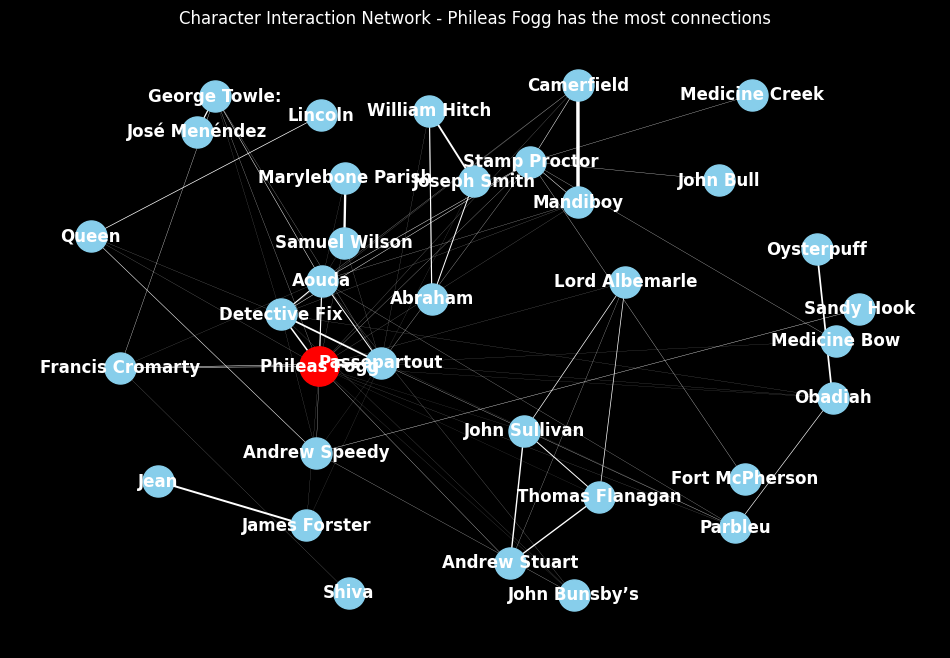

In [ ]:
connections = calculate_connections(real_characters_location)

# Filter and sort connections based on a threshold (example)
filtered_connections = [(x, y, z) for x, y, z in connections if z > 0.01]
filtered_connections = sorted(filtered_connections, key=lambda x: x[2], reverse=True)

# Visualization (optional)
R = nx.Graph()

# Add edges to the graph
for character1, character2, weight in filtered_connections:
    R.add_edge(character1, character2, weight=weight)
degree_dict = dict(R.degree())

# Find the character with the most connections
max_degree_character = max(degree_dict, key=degree_dict.get)
max_degree = degree_dict[max_degree_character]

# Visualization (optional)
# Generate positions using the Spring Layout
pos = nx.spring_layout(R, k=0.5, iterations=50)  # Adjust k for spacing

# Draw the graph
plt.figure(figsize=(12, 8), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')  # Set the background color to black

nx.draw_networkx_nodes(R, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(R, pos, font_size=12, font_weight='bold', font_color='white')  # Set font color to white

# Draw edges with weights
edges = nx.draw_networkx_edges(R, pos, edge_color='white', width=[R[u][v]['weight'] * 5 for u, v in R.edges()])  # Set edge color to white

# Highlight the node with the most connections in red
nx.draw_networkx_nodes(R, pos, nodelist=[max_degree_character], node_color='red', node_size=800)

# Show the plot
plt.title(f"Character Interaction Network - {max_degree_character} has the most connections", color='white')  # Set title color to white
plt.axis('off')
plt.show()

In [ ]:
# Print the result
print(f"Character with the most connections (largest number of arcs): {max_degree_character} with {max_degree} connections")

In [ ]:
connections = calculate_connections(real_characters_location)

# Filter and sort connections based on a threshold (example)
filtered_connections = [(x, y, z) for x, y, z in connections if z > 0.01]
filtered_connections = sorted(filtered_connections, key=lambda x: x[2], reverse=True)

# Visualization (optional)
R = nx.Graph()

# Add edges to the graph
for character1, character2, weight in filtered_connections:
    R.add_edge(character1, character2, weight=weight)

# Calculate the sum of connections for each character
connection_sums = {}
for character1, character2, data in R.edges(data=True):
    if character1 not in connection_sums:
        connection_sums[character1] = 0
    if character2 not in connection_sums:
        connection_sums[character2] = 0
    connection_sums[character1] += data['weight']
    connection_sums[character2] += data['weight']

# Find the character with the highest sum of connections
max_character = max(connection_sums, key=connection_sums.get)
max_sum = connection_sums[max_character]

# Generate positions using the Spring Layout
pos = nx.spring_layout(R, k=0.5, iterations=50)  # Adjust k for spacing

# Draw the graph
plt.figure(figsize=(12, 8), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')  # Set the background color to black

nx.draw_networkx_nodes(R, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(R, pos, font_size=12, font_weight='bold', font_color='white')  # Set font color to white

# Draw edges with weights
edges = nx.draw_networkx_edges(R, pos, edge_color='white', width=[R[u][v]['weight'] * 5 for u, v in R.edges()])  # Set edge color to white

# Highlight the node with the highest sum of connections in red
nx.draw_networkx_nodes(R, pos, nodelist=[max_character], node_color='red', node_size=800)

# Show the plot
plt.title(f"Character Interaction Network - {max_character} has the highest sum of connections", color='white')  # Set title color to white
plt.axis('off')
plt.show()

In [ ]:
# Print the result
print(f"Character with the highest sum of connections: {max_character} with a sum of {max_sum:.2f}")

In [ ]:
average_locations = {}

for character, locations in real_characters_location.items():
    avg_page = sum(loc[0] for loc in locations) / len(locations)
    average_locations[character] = avg_page

# Sort the average locations by average page
sorted_average_locations = sorted(average_locations.items(), key=lambda x: x[1])

# Print the sorted average locations
print("Average appearance location (page) for each character, sorted by average page:")
for character, avg_page in sorted_average_locations:
    print(f"{character}: Page {avg_page:.2f}")

In [ ]:
from matplotlib.patches import Patch

# Define the color map for different ranges of average appearance pages
color_map = {
    '0-100': 'lightgreen',
    '100-165': 'skyblue',
    '165-200': 'orange',
    '200-242': 'lightcoral'
}

sorted_average_locations = sorted(average_locations.items(), key=lambda x: x[1])

highlight_characters_red = ['Phileas Fogg']
highlight_characters_grey = ['Detective Fix', 'Passepartout', 'Aouda']
highlight_color_red = 'red'
highlight_color_grey = 'grey'

# Extract characters and their average pages
characters = [item[0] for item in sorted_average_locations]
avg_pages = [item[1] for item in sorted_average_locations]

# Assign colors based on average page ranges
bar_colors = []
for character, avg_page in zip(characters, avg_pages):
    if character in highlight_characters_red:
        bar_colors.append(highlight_color_red)
    elif character in highlight_characters_grey:
        bar_colors.append(highlight_color_grey)
    elif avg_page <= 100:
        bar_colors.append(color_map['0-100'])
    elif 100 < avg_page <= 165:
        bar_colors.append(color_map['100-165'])
    elif 165 < avg_page <= 200:
        bar_colors.append(color_map['165-200'])
    else:
        bar_colors.append(color_map['200-242'])

# Create a bar chart with different colors
plt.figure(figsize=(15, 10))
plt.barh(characters, avg_pages, color=bar_colors)
plt.xlabel('Average Appearance Page')
plt.ylabel('Characters')
plt.title('Average Appearance Location (Page) for Each Character')

# Add a legend
legend_handles = [
    Patch(color=color_map['0-100'], label='Pages 0-100'),
    Patch(color=color_map['100-165'], label='Pages 100-165'),
    Patch(color=color_map['165-200'], label='Pages 165-200'),
    Patch(color=color_map['200-242'], label='Pages 200-242'),
    Patch(color=highlight_color_red, label='Highlighted Main Character: Phileas Fogg'),
    Patch(color=highlight_color_grey, label='Highlighted Minor Characters: Fix, Passepartout, Aouda')
]
plt.legend(handles=legend_handles)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


***What are the social circles of the characters?***

In [ ]:
T = nx.Graph()

for character1, character2, weight in filtered_connections:
    T.add_edge(character1, character2, weight=weight)

pos = nx.spring_layout(T, k=0.5, iterations=50)

plt.figure(figsize=(25, 30), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')

nx.draw_networkx_nodes(T, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(T, pos, font_size=12, font_weight='bold', font_color='white')

edges = nx.draw_networkx_edges(T, pos, edge_color='white', width=[T[u][v]['weight'] * 10 for u, v in T.edges()])


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in T.edges(data=True)}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, font_size=10, font_color='black')

# הצגת הגרף
plt.title("Character Interaction Network - Spring Layout", color='white')
plt.axis('off')
plt.show()

In [ ]:
from itertools import cycle

components = list(nx.connected_components(T))
component_colors = cycle(['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink', 'lightgray'])

color_map = {}
for color, component in zip(component_colors, components):
    for node in component:
        color_map[node] = color

# Draw the graph
plt.figure(figsize=(25, 30), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')  # Set the background color to black

nx.draw_networkx_nodes(T, pos, node_color=[color_map[node] for node in T.nodes()], node_size=500)
nx.draw_networkx_labels(T, pos, font_size=12, font_weight='bold', font_color='white')  # Set font color to white

# Draw edges with weights
edges = nx.draw_networkx_edges(T, pos, edge_color='white', width=[T[u][v]['weight'] * 10 for u, v in T.edges()])  # Set edge color to white

# Draw edge labels
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in T.edges(data=True)}
nx.draw_networkx_edge_labels(R, pos, edge_labels=edge_labels, font_size=10, font_color='black')  # Set edge label color to white

# Show the plot
plt.title("Character Interaction Network - Spring Layout", color='white')  # Set title color to white
plt.axis('off')
plt.show()

In [ ]:
print("Connected Components:")
for i, component in enumerate(components):
    print(f"Component {i+1}: {component}")

In [ ]:
def check_graph_directionality(graph):
    if isinstance(graph, nx.DiGraph):
        return "Directed"
    else:
        return "Undirected"

graph_type = check_graph_directionality(R)
print(f"Is the graph directed? {graph_type}")

Is the graph directed? Undirected


In [ ]:
from collections import defaultdict

co_occurrence = defaultdict(int)

# Iterate through all pages and lines where characters appear
for locations in real_characters_location.values():
    for page_line in locations:
        characters_on_same_page_line = [char for char, loc in real_characters_location.items() if page_line in loc]
        for char1, char2 in itertools.combinations(characters_on_same_page_line, 2):
            co_occurrence[frozenset([char1, char2])] += 1

# Sort co-occurrences by frequency
sorted_co_occurrence = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)

# Get the top pairs
top_pairs = sorted_co_occurrence[:10]
print("Top character pairs that appear most frequently together:")
for pair, count in top_pairs:
    print(f"{list(pair)}: {count} times")

Top character pairs that appear most frequently together:
['Aouda', 'Phileas Fogg']: 73 times
['Detective Fix', 'Phileas Fogg']: 66 times
['Passepartout', 'Detective Fix']: 55 times
['Passepartout', 'Phileas Fogg']: 51 times
['Francis Cromarty', 'Phileas Fogg']: 36 times
['Passepartout', 'Aouda']: 30 times
['Detective Fix', 'Aouda']: 19 times
['Stamp Proctor', 'Phileas Fogg']: 7 times
['Andrew Stuart', 'Phileas Fogg']: 4 times
['Francis Cromarty', 'Passepartout']: 4 times


***What is the strength of the relationship between the characters?***

In [ ]:
filtered_connections = sorted(filtered_connections, key=lambda x: x[2], reverse=True)

T = nx.Graph()
for character1, character2, weight in filtered_connections:
    T.add_edge(character1, character2, weight=weight)

pos = nx.spring_layout(T, k=0.2, iterations=10)

color_map = {name: 'skyblue' for name in T.nodes()}

strongest_connections = sorted(T.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]

plt.figure(figsize=(25, 30))
nx.draw_networkx_nodes(T, pos, node_color=[color_map[node] for node in T.nodes()], node_size=500)
nx.draw_networkx_labels(T, pos, font_size=12, font_weight='bold', font_color='black')

all_edges = nx.draw_networkx_edges(T, pos, edge_color='gray', width=[T[u][v]['weight']*5 for u, v in T.edges()])

strongest_edges = nx.draw_networkx_edges(T, pos, edgelist=strongest_connections, edge_color='red', width=5)

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in T.edges(data=True)}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, font_size=10)

plt.title("Character Interaction Network - Spring Layout with Strongest Connections Highlighted")
plt.axis('off')
plt.show()

In [ ]:
print("Strongest Connections:")
for connection in strongest_connections:
    character1, character2, data = connection
    print(f"{character1} - {character2}: {data['weight']:.2f}")